<h1 style="text-align: center;">Santander Modelling</h1>
<h3 style="text-align: center;">Candidate 26527, Candidate 24738, Candidate 25411 , Candidate 34553</h3>

#### *Table of Contents*

<ul>
    <li><a href = "#Packages"> Packages </a></li>
    <li> <a href = "#Loading the Dataset">Loading the Dataset</a></li>
    <ul>
            <li><a href = "#Scraping the public holidays">Scraping the public holidays</a></li>
            <li><a href = "#Loading the weather data">Loading the weather data</a></li>
          </ul>  
    <li><a href="#EDA">EDA</a></li>
    <ul>
        <li> <a href = "#Chisquare test">Chisquare test</a> </li>
        <li> <a href="#Correlation Plot">Correlation plot</a></li>
    </ul>
    <li> <a href="#Demand Prediction">Demand Prediction</a></li>
        <ul>
            <li><a href = "#Data Preprocessing and creating pipelines ">Data Preprocessing and creating pipelines </a></li>
            <li><a href = "#Linear Regression Model">Linear Regression Model</a></li>
            <li><a href = "#Gradient Boosted Trees Regressor Model">Gradient Boosted Trees Regressor Model</a></li>
            <li><a href = "#Random Forest Regressor Model">Random Forest Regressor Model</a></li>
                <ul>
                    <li><a href = "#Feature Importance Visualization (GBT and Random Forest)">Feature Importance Visualization (GBT and Random Forest)</a></li>
                    <li><a href = "#Predicting Total Duration values using GBT Regressor Model">Predicting Total Duration values using GBT Regressor Model</a></li>
            </ul>
    </ul>
     <li> <a href = "#Revenue Analysis and forecasting using various Time Series Models">Revenue Analysis and forecasting using various Time Series Models</a></li>
    <ul>
        <li><a href = "#Arima - Autoregressive Integrated Moving Average model">Arima - Autoregressive Integrated Moving Average model</a></li>
        <ul>
            <li><a href = "#Hyper parameter tuning of the p,d and q parameters">Hyper parameter tuning of the p,d and q parameters</a></li>
            <li><a href = "#Forecasting using the ARIMA model">Forecasting using the ARIMA model</a></li>
        </ul>
        <li><a href = "#SARIMA - Seasonal Autoregressive Integrated Moving Average model">SARIMA - Seasonal Autoregressive Integrated Moving Average model</a></li>
        <ul>
            <li><a href = "#Hyper parameter tuning of p, d, q, P, D and Q parameters">Hyper parameter tuning of p, d, q, P, D and Q parameters</a></li>
            <li><a href = "#Forecast using the SARIMA model">Forecast using the SARIMA model</a></li>
        </ul>
        <li><a href = "#LSTM - Long Short term memory networks">LSTM - Long Short term memory networks</a></li>
        <li><a href="#Combined Forecasts for the three models">Combined Forecasts for the three models</a></li>

# Packages <a id="Packages"></a>

In [13]:
from pyspark.sql.functions import col, isnan, when, count, unix_timestamp, floor, sum, to_date, round,max
from pyspark.sql.functions import hour, avg, concat, lit, dayofweek, date_format
import pandas as pd
import numpy as np
import math
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth, hour, col
! pip install pyspark_dist_explore
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lit, lag
from statsmodels.graphics.tsaplots import plot_acf
# Set the logging level to suppress warnings
import warnings
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, size,array,concat,lit, collect_list, array_repeat, concat_ws, Column
# Suppressing warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
import requests
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.linalg import Vectors
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import unix_timestamp, from_unixtime, to_timestamp
#!pip install numpy==1.19.5
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_pacf

from keras.metrics import RootMeanSquaredError
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import datetime
import statsmodels.api as sm

# correlation plot
from pyspark.ml.stat import Correlation
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 642.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 108.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 102.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.7 MB/s eta 0:00:00:00:01
   ━━━━━━━

2024-04-24 23:01:32.231353: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

2024-04-24 23:01:32.314387: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 23:01:33.856596: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 23:01:36.538474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

# Loading the Dataset <a id="Loading the Dataset"></a>

In [4]:
# Initialize Spark Session
spark = SparkSession.builder.appName("BigQuery Read").getOrCreate()

# Dataset name
dataset_name = "london_bicycles"

# Table names
cycle_hire_table_name = "cycle_hire"
cycle_stations_table_name = "cycle_stations"

# Full table IDs including project, dataset, and table names
cycle_hire_table_id = f"bigquery-public-data.{dataset_name}.{cycle_hire_table_name}"
cycle_stations_table_id = f"bigquery-public-data.{dataset_name}.{cycle_stations_table_name}"

# Read data from the cycle_hire table in BigQuery
cycle_hire_df = spark.read.format("bigquery").option("table", cycle_hire_table_id).load()

# Read data from the cycle_stations table in BigQuery
cycle_stations_df = spark.read.format("bigquery").option("table", cycle_stations_table_id).load()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/24 22:44:02 INFO SparkEnv: Registering MapOutputTracker
24/04/24 22:44:02 INFO SparkEnv: Registering BlockManagerMaster
24/04/24 22:44:02 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/04/24 22:44:02 INFO SparkEnv: Registering OutputCommitCoordinator


In [5]:
#cycle hires filtered by year
hires = cycle_hire_df.filter((year(cycle_hire_df["start_date"]).isin([2019, 2020])) & (year(cycle_hire_df["end_date"]).isin([2019, 2020])))
#hires.show()
initial_hires_count = hires.count()
#from pyspark.sql.functions import col

# Ensure the station IDs are integers in both DataFrames if they are not already
cycle_stations_df = cycle_stations_df.withColumn("id", col("id").cast("integer"))

hires = hires.withColumn("start_station_id", col("start_station_id").cast("integer")) \
             .withColumn("end_station_id", col("end_station_id").cast("integer"))

# Join the hires DataFrame with the start and end station details from cycle_stations_df
# Start Station Join
hires_with_start_stations = hires.join(
    cycle_stations_df,
    hires.start_station_id == cycle_stations_df.id,
    how='left'
).select(hires["*"],
         col("latitude").alias("start_station_latitude"),
         col("longitude").alias("start_station_longitude"))

# End Station Join
hires_with_stations = hires_with_start_stations.join(
    cycle_stations_df,
    hires_with_start_stations.end_station_id == cycle_stations_df.id,
    how='left'
).select(
    hires_with_start_stations["*"],
    col("latitude").alias("end_station_latitude"),
    col("longitude").alias("end_station_longitude")
)

In [6]:
# Extract hour from the "start_date" column
grouped_df = hires_with_stations.withColumn("hour_of_day", hour("start_date"))

# Convert 'duration' to integer
grouped_df = grouped_df.withColumn("duration", col("duration").cast("int"))

# Now perform the grouping and aggregation
result_df = grouped_df.groupBy("hour_of_day", "start_date").agg(
    count("*").alias("total_rentals"),
    sum("duration").alias("total_duration")
)


# Add day_of_week column using date_format to extract day name from the date
result_df = result_df.withColumn("day_of_week", date_format("start_date", "E"))

# Concatenate date and hour_of_day to form the new date column
# Here we cast the start_date to date format and concatenate it with the hour_of_day
result_df = result_df.withColumn("date", concat(result_df["start_date"].cast("date"), lit(" "), result_df["hour_of_day"].cast("string")))

# Select only the required columns
demand_data = result_df.select("date", "total_rentals", "total_duration", "day_of_week")


## Scraping the public holidays <a id="Scraping the public holidays"></a>

In [7]:
url = "https://www.gov.uk/bank-holidays.json"

# Send HTTP request to get the JSON data
response = requests.get(url)

# Check if the response is successful
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()

    # Extract the required data for the DataFrame
    holiday_data = []
    for year_data in data["england-and-wales"]["events"]:
        holiday_data.append((year_data["date"], year_data["title"]))

    # Create a DataFrame from the extracted data
    df = spark.createDataFrame(holiday_data, ["Date", "Holiday"])
    filtered_df = df.filter((year(df["Date"]) >= 2019) & (year(df["Date"]) <= 2022))

    # Show the filtered DataFrame
    filtered_df.show()
else:
    print("Failed to fetch data. Status code:", response.status_code)



+----------+--------------------+
|      Date|             Holiday|
+----------+--------------------+
|2019-01-01|      New Year’s Day|
|2019-04-19|         Good Friday|
|2019-04-22|       Easter Monday|
|2019-05-06|Early May bank ho...|
|2019-05-27| Spring bank holiday|
|2019-08-26| Summer bank holiday|
|2019-12-25|       Christmas Day|
|2019-12-26|          Boxing Day|
|2020-01-01|      New Year’s Day|
|2020-04-10|         Good Friday|
|2020-04-13|       Easter Monday|
|2020-05-08|Early May bank ho...|
|2020-05-25| Spring bank holiday|
|2020-08-31| Summer bank holiday|
|2020-12-25|       Christmas Day|
|2020-12-28|          Boxing Day|
|2021-01-01|      New Year’s Day|
|2021-04-02|         Good Friday|
|2021-04-05|       Easter Monday|
|2021-05-03|Early May bank ho...|
+----------+--------------------+
only showing top 20 rows



Preprocessing the public holiday data

In [8]:
# Convert the date column in public_holiday to DateType
filtered_df = filtered_df.withColumn("Date", to_date(col("Date")))

# Join hires_with_stations with public_holiday on the date part of start_date
joined_df = demand_data.join(filtered_df,
                             demand_data["date"].cast("date") == filtered_df["Date"],
                             "left_outer")

# Add a new column "public_holiday" and set its value to 1 if there's a match, 0 otherwise
demand_data_complete = joined_df.withColumn("public_holiday",
                                     (col("Holiday").isNotNull()).cast("int")).drop(filtered_df["Date"]).drop("Holiday")

In [9]:
# Group by 'date', which includes the hour, and 'day_of_week', and aggregate
aggregated_df = demand_data_complete.groupBy("date", "day_of_week").agg(
    sum("total_rentals").alias("total_rentals"),  # Total rentals per date and hour
    sum("total_duration").alias("total_duration"),  # Total duration per date and hour
    max("public_holiday").alias("public_holiday")  # Max ensures it is 1 if any match is found for public holiday
)

# Sort the aggregated DataFrame by the 'date' column in descending order
sorted_aggregated_df = aggregated_df.orderBy(col("date").desc())

## Loading the weather data <a id="Loading the weather data"></a>

In [10]:
# Load the weather data from HDFS
weather_data = spark.read.csv('hdfs:///user/anushka/newdir/cleaned_sorted_weather_data.csv', header=True, inferSchema=True)
weather_data = weather_data.withColumn("datetime", to_timestamp("datetime", 'yyyy-MM-dd HH:mm:ss'))

# Convert the date column of demand_data_complete to the correct datetime format
sorted_aggregated_df = sorted_aggregated_df.withColumn("datetime", to_timestamp("date", 'yyyy-MM-dd H'))

# Perform the inner join on the 'datetime' column
merged_data = sorted_aggregated_df.join(weather_data, "datetime", "inner")

# Drop the redundant 'date' column from demand_data_complete
if "date" in sorted_aggregated_df.columns:
    merged_data = merged_data.drop(sorted_aggregated_df["date"])

In [11]:
# Sort the DataFrame by the 'date' column in descending order
merged_data = merged_data.orderBy(col("datetime").desc())

# Initialize Spark session
spark = SparkSession.builder.appName("DataModification").getOrCreate()


# Converting total duration in milleseconds to seconds
merged_data = merged_data.withColumn("total_duration", col("total_duration") / 1000)

# Show merged DataFrame
merged_data.show()


24/04/24 22:50:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+-----------+-------------+--------------+--------------+------+----+--------+------+---------+----------------+----------------+
|           datetime|day_of_week|total_rentals|total_duration|public_holiday|  name|temp|humidity|precip|windspeed|sealevelpressure|      conditions|
+-------------------+-----------+-------------+--------------+--------------+------+----+--------+------+---------+----------------+----------------+
|2020-12-31 23:00:00|        Thu|          361|        379.14|             0|London| 1.6|   86.63|   0.0|      3.5|          1008.9|        Overcast|
|2020-12-31 22:00:00|        Thu|          427|        570.18|             0|London| 1.6|   86.62|   0.0|      4.5|          1008.6|        Overcast|
|2020-12-31 21:00:00|        Thu|          435|         654.9|             0|London| 1.5|   85.36|   0.0|      3.9|          1008.3|        Overcast|
|2020-12-31 20:00:00|        Thu|          471|        636.12|             0|London| 1.1|   87.83|  

# EDA<a id="EDA"></a>

## Chisquare test <a id="Chisquare test"></a>

In [4]:
# Perform StringIndexer to convert categorical variables into numeric indices
indexer1 = StringIndexer(inputCol="start_station_name", outputCol="start_station_index")
indexer2 = StringIndexer(inputCol="end_station_name", outputCol="end_station_index")
indexed_df = indexer1.fit(hires_with_stations).transform(hires_with_stations)
indexed_df = indexer2.fit(indexed_df).transform(indexed_df)

assembler = VectorAssembler(inputCols=["end_station_index"], outputCol="features")
assembled_df = assembler.transform(indexed_df).select(col("start_station_index").alias("label"), "features")

# Perform Chi-Square test of independence
chi_square_result = ChiSquareTest.test(assembled_df, "features", "label").head()

# Print the results
print("Chi-Square Statistic:", chi_square_result.pValues[0])
print("P-value:", chi_square_result.pValues[0])

# Interpret the results
alpha = 0.05  # significance level
if chi_square_result.pValues[0] < alpha:
    print("There is a significant relationship between the 'start_station_name' and 'end_station_name' columns.")
else:
    print("There is no significant relationship between the 'start_station_name' and 'end_station_name' columns.")


Chi-Square Statistic: 0.0
P-value: 0.0
There is a significant relationship between the 'start_station_name' and 'end_station_name' columns.


## Correlation Plot <a id="Correlation Plot"></a>

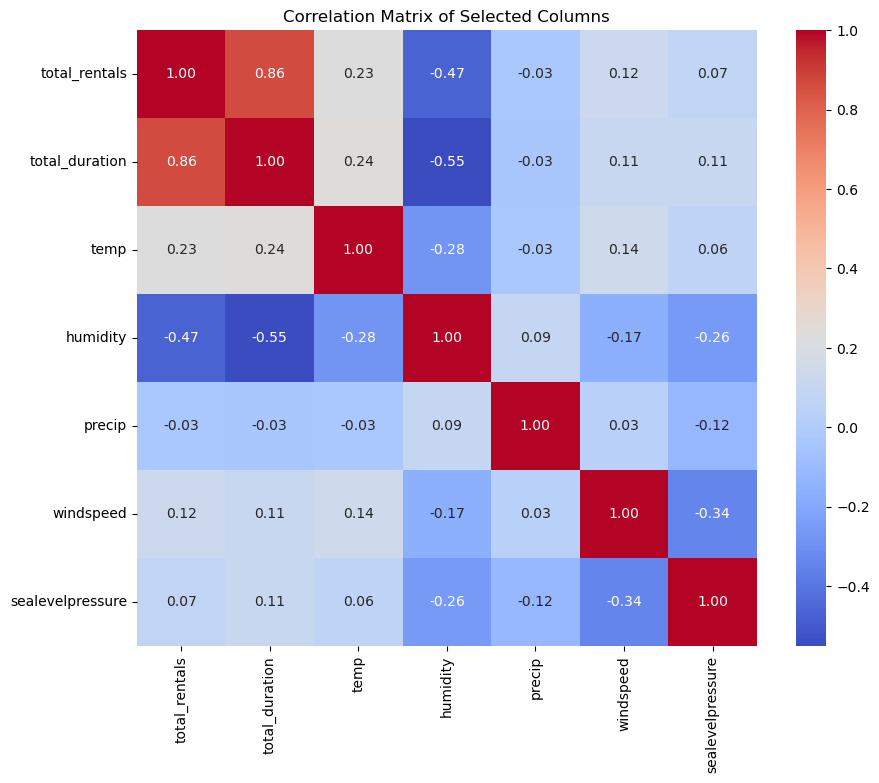

In [12]:
# Selecting the numeric colums
columns_of_interest = ['total_rentals', 'total_duration', 'temp','humidity','precip','windspeed','sealevelpressure']

# Converting columns to a vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns_of_interest, outputCol=vector_col)
df_vector = assembler.transform(merged_data).select(vector_col)

# Computing the correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.toArray(), annot=True, cmap='coolwarm', fmt=".2f", xticklabels=columns_of_interest, yticklabels=columns_of_interest)
plt.title('Correlation Matrix of Selected Columns')
plt.show()

# Demand Prediction <a id="Demand Prediction"></a>

## Data Preprocessing and creating pipelines <a id="Data Preprocessing and creating pipelines"></a>

In [11]:
# Initialize Spark session
spark = SparkSession.builder.appName("DemandPredictionModels").getOrCreate()

# Extract date-time components
data = merged_data.withColumn("year", year("datetime"))\
                  .withColumn("month", month("datetime"))\
                  .withColumn("day", dayofmonth("datetime"))\
                  .withColumn("hour", hour("datetime"))

# Encode categorical variables
indexer_day_of_week = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_Index")
encoder_day_of_week = OneHotEncoder(inputCols=["day_of_week_Index"], outputCols=["day_of_week_Vec"])
indexer_public_holiday = StringIndexer(inputCol="public_holiday", outputCol="public_holiday_Index")
encoder_public_holiday = OneHotEncoder(inputCols=["public_holiday_Index"], outputCols=["public_holiday_Vec"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["public_holiday_Vec", "day_of_week_Vec", "temp", "humidity", "precip",
               "windspeed", "sealevelpressure", "total_rentals", "year", "month", "day", "hour"],
    outputCol="raw_features"
)

# Apply StandardScaler
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

# Sort data by datetime
data = data.sort(col("datetime"))

# Randomly split the data into training and testing sets (70% training, 30% testing)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)


24/04/24 20:08:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [12]:
# Set the seed for reproducibility
seed = 42
spark.conf.set("spark.sql.shuffle.partitions", "8")  # Set the number of shuffle partitions for better performance
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")  # Enable Arrow optimization for better performance
spark.conf.set("spark.executorEnv.PYTHONHASHSEED", str(seed))  # Set the Python hash seed
spark.conf.set("spark.sql.execution.randomSeed", str(seed))  # Set the random seed for Spark SQL operations

## Linear Regression Model <a id="Linear Regression Model"></a>

In [14]:
# Linear Regression setup
lr = LinearRegression(featuresCol="features", labelCol="total_duration", maxIter=100, regParam=0.01)

pipeline_lr = Pipeline(stages=[indexer_day_of_week, encoder_day_of_week, indexer_public_holiday, encoder_public_holiday, assembler, scaler, lr])

# Fit the model
model_lr = pipeline_lr.fit(train_data)

# Make predictions
predictions_lr = model_lr.transform(test_data)

# Evaluate the model
evaluator_lr = RegressionEvaluator(labelCol="total_duration", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator_lr.evaluate(predictions_lr)
print("Linear Regression RMSE on testing data: ", rmse_lr)


Linear Regression RMSE on testing data:  957.2128476992034


## Gradient Boosted Trees Regressor Model <a id="Gradient Boosted Trees Regressor Model"></a>

In [18]:
# GBT Regressor setup
gbt = GBTRegressor(featuresCol="features", labelCol="total_duration", maxDepth=5, maxIter=100, stepSize=0.1)
pipeline_gbt = Pipeline(stages=[indexer_day_of_week, encoder_day_of_week, indexer_public_holiday, encoder_public_holiday, assembler, scaler, gbt])

# Fit the model
model_gbt = pipeline_gbt.fit(train_data)

# Make predictions
predictions_gbt = model_gbt.transform(test_data)

# Evaluate the model
evaluator_gbt = RegressionEvaluator(labelCol="total_duration", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator_gbt.evaluate(predictions_gbt)
print("GBT Regressor RMSE on testing data: ", rmse_gbt)

GBT Regressor RMSE on testing data:  435.0667192270907


## Random Forest Regressor Model<a id="Random Forest Regressor Model"></a>

In [19]:
# Random Forest setup
rf = RandomForestRegressor(featuresCol="features", labelCol="total_duration", numTrees=50, maxDepth=10, seed=42)
pipeline_rf = Pipeline(stages=[indexer_day_of_week, encoder_day_of_week, indexer_public_holiday, encoder_public_holiday, assembler, scaler, rf])

# Fit the model
model_rf = pipeline_rf.fit(train_data)

# Make predictions
predictions_rf = model_rf.transform(test_data)

# Evaluate the model
evaluator_rf = RegressionEvaluator(labelCol="total_duration", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator_rf.evaluate(predictions_rf)
print("Random Forest Regressor RMSE on testing data: ", rmse_rf)

Random Forest Regressor RMSE on testing data:  440.0950939811706


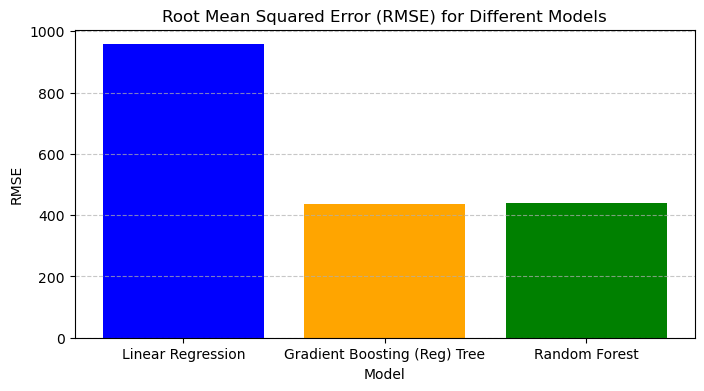

In [20]:
# RMSE values for three models
rmse_values = [rmse_lr, rmse_gbt, rmse_rf]
model_names = ['Linear Regression', 'Gradient Boosting (Reg) Tree', 'Random Forest']

# Plotting the bar chart
plt.figure(figsize=(8, 4))
plt.bar(model_names, rmse_values, color=['blue', 'orange', 'green'])
plt.title('Root Mean Squared Error (RMSE) for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
#plt.ylim(0, max(rmse_values) * 1.1)  # Set y-axis limit to slightly above the maximum RMSE value
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This shows that the lowest RMSE value on unseen data is achieved by the GBT Regressor model: 435.066.

### Feature Importance Visualization (GBT and Random Forest)<a id="Feature Importance Visualization (GBT and Random Forest)"></a> 

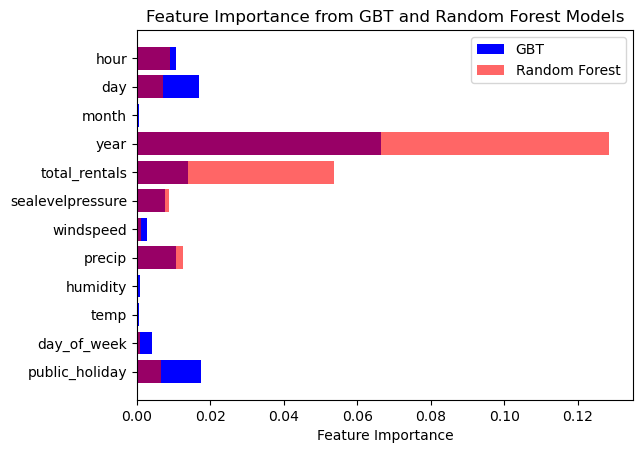

In [21]:
# Assuming `model_gbt` and `model_rf` are trained models
features = ["public_holiday", "day_of_week", "temp", "humidity", "precip", "windspeed", "sealevelpressure", "total_rentals", "year", "month", "day", "hour"]
importances_gbt = model_gbt.stages[-1].featureImportances
importances_rf = model_rf.stages[-1].featureImportances

# Convert to Python list for plotting
importances_gbt_list = [importances_gbt[i] for i in range(len(features))]
importances_rf_list = [importances_rf[i] for i in range(len(features))]

# Plot
fig, ax = plt.subplots()
indices = range(len(features))
ax.barh(indices, importances_gbt_list, color='b', label='GBT')
ax.barh(indices, importances_rf_list, color='r', alpha=0.6, label='Random Forest')
ax.set_yticks(indices)
ax.set_yticklabels(features)
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance from GBT and Random Forest Models')
ax.legend()
plt.show()


### Predicting Total Duration values using GBT Regressor Model<a id="Predicting Total Duration values using GBT Regressor Model"></a>

Extracting the predicted values of the total_duration for the entire dataset using the GBT regressor model

In [13]:
# GBT Regressor setup
gbt = GBTRegressor(featuresCol="features", labelCol="total_duration", maxDepth=5, maxIter=100, stepSize=0.1)
#gbt = GBTRegressor(featuresCol="features", labelCol="total_duration")

# Pipeline setup including the scaler
pipeline_gbt = Pipeline(stages=[indexer_day_of_week, encoder_day_of_week, indexer_public_holiday, encoder_public_holiday, assembler, scaler, gbt])

# Fit the model on the entire dataset
model_final_gbt = pipeline_gbt.fit(data)

# Make predictions on the entire dataset
predictions_final_gbt = model_final_gbt.transform(data)

# Show all predictions
predictions_final_gbt.select("datetime", "total_duration", "prediction").show(n=predictions_final_gbt.count(), truncate=False)

# Evaluate the model
evaluator_final_gbt = RegressionEvaluator(labelCol="total_duration", predictionCol="prediction", metricName="rmse")
rmse_final_gbt = evaluator_final_gbt.evaluate(predictions_final_gbt)




24/04/24 20:13:55 ERROR TransportClient: Failed to send RPC RPC 6333749218461307846 to /10.172.0.16:44804: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
24/04/24 20:13:55 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 924 from block manager BlockManagerId(5, st446-final-gp-w-0.europe-west6-c.c.decent-stacker-411610.internal, 36801, None)
java.io.IOException: Failed to send RPC RPC 6333749218461307846 to /10.172.0.16:44804: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.2.jar:3.3.2]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3

# Revenue Analysis and forecasting using various Time Series Models<a id="Revenue Analysis and forecasting using various Time Series Models"></a>

In [14]:
total_duration = predictions_final_gbt.select("datetime", "total_duration", "prediction")

In [15]:
# Define a UDF to calculate revenue based on duration
def calculate_revenue(duration_seconds):
    base_fare = 1.65
    additional_fare_per_30_minutes = 1.65
    duration_minutes = duration_seconds / 60
    total_fare = base_fare + ((duration_minutes - 30) // 30) * additional_fare_per_30_minutes
    return total_fare

# Register the UDF
spark.udf.register("calculate_revenue_udf", calculate_revenue)

# Calculate actual_revenue and predicted_revenue
result = total_duration.withColumn("actual_revenue", col("total_duration") / 60) \
           .withColumn("predicted_revenue", col("prediction") / 60) \
           .withColumn("actual_revenue", floor(col("actual_revenue") + 0.5)) \
           .withColumn("predicted_revenue", floor(col("predicted_revenue") + 0.5)) \
           .withColumn("actual_revenue", col("actual_revenue") * 1.65) \
           .withColumn("predicted_revenue", col("predicted_revenue") * 1.65)


In [16]:
# Group by date and sum the actual_revenue and predicted_revenue
grouped_result = result.withColumn("date", to_date("datetime")) \
                       .groupBy("date") \
                       .agg(round(sum("actual_revenue"),2).alias("actual_revenue_day"),
                            round(sum("predicted_revenue"),2).alias("predicted_revenue_day")) \
                       .orderBy("date")



In [17]:
grouped_result.show(5)

+----------+------------------+---------------------+
|      date|actual_revenue_day|predicted_revenue_day|
+----------+------------------+---------------------+
|2019-01-01|             653.4|                630.3|
|2019-01-02|             594.0|                531.3|
|2019-01-03|            595.65|               585.75|
|2019-01-04|            569.25|                554.4|
|2019-01-05|            417.45|               447.15|
+----------+------------------+---------------------+
only showing top 5 rows



In [18]:
# Converting the dataframe to pandas dataframe

revenue_df = grouped_result.toPandas()
# Convert 'date' column to datetime type
revenue_df['date'] = pd.to_datetime(revenue_df['date'])

# Set 'date' column as index
revenue_df.set_index('date', inplace=True)

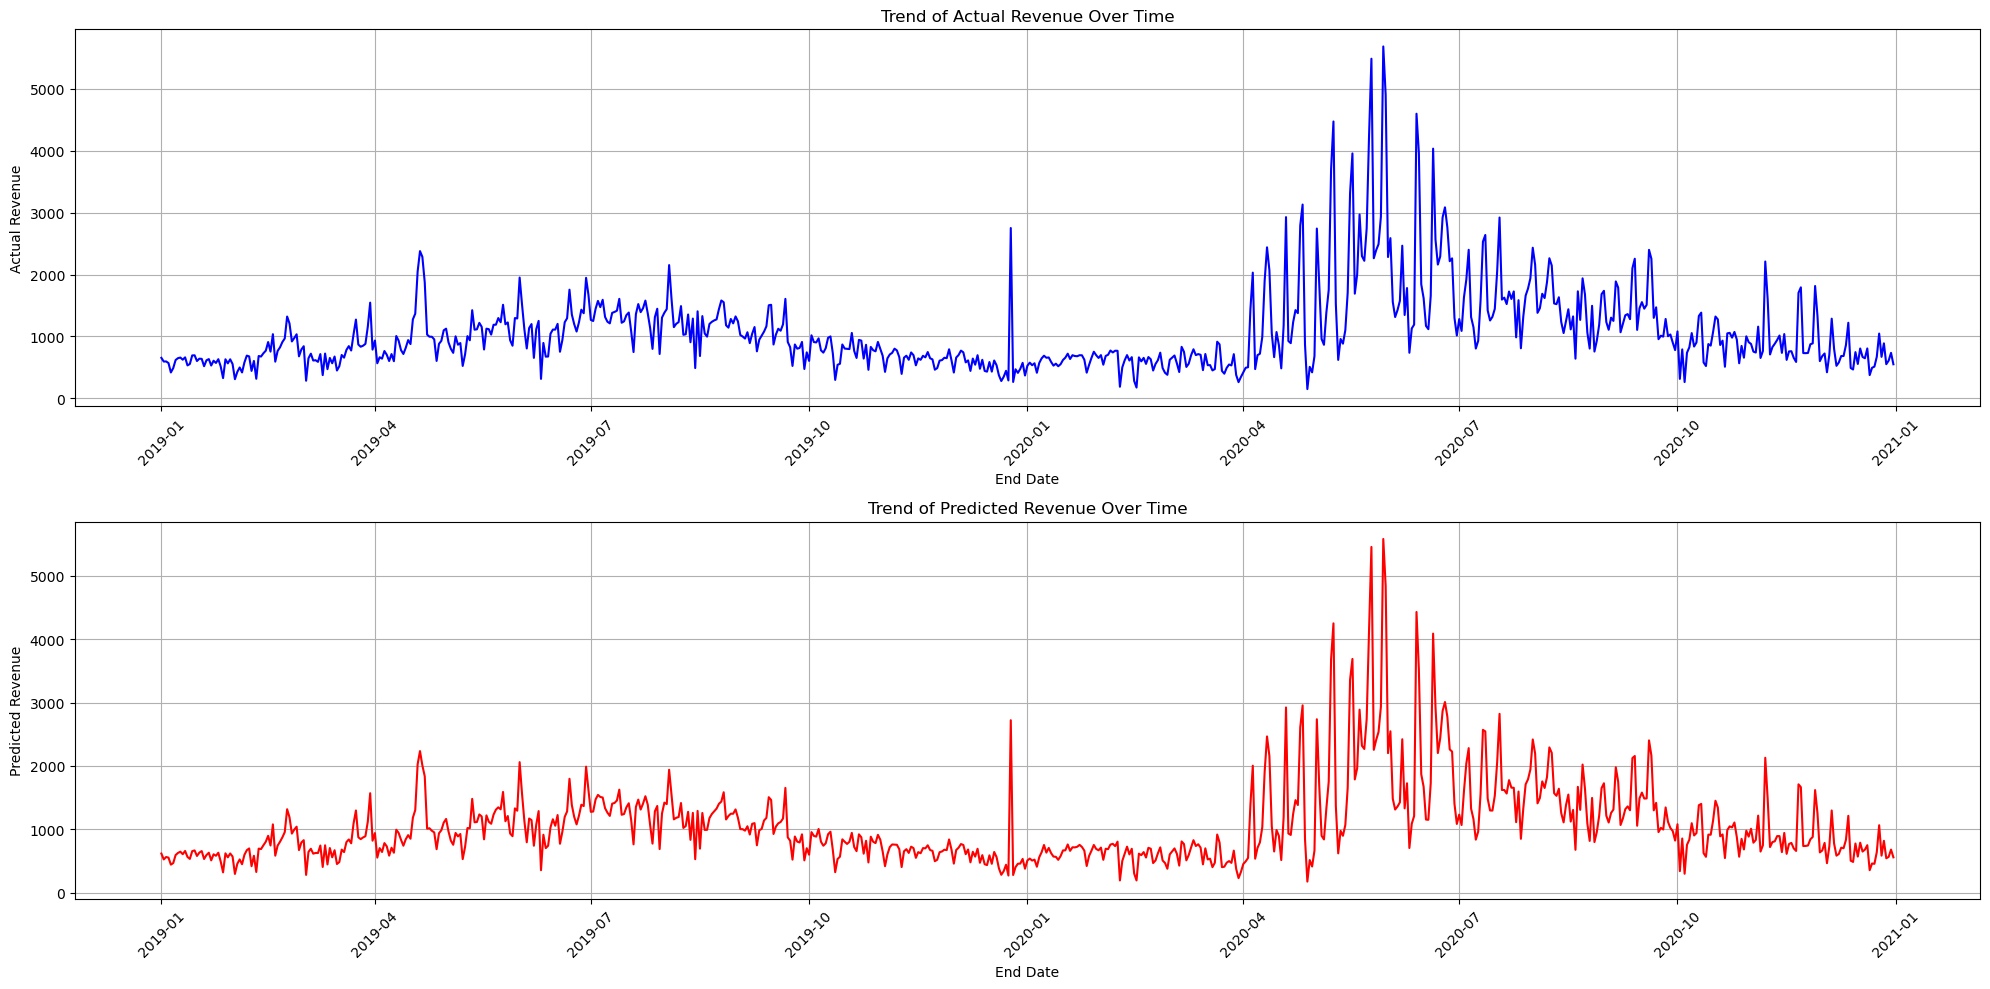

In [30]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Plot actual revenue
axes[0].plot(revenue_df.index, revenue_df['actual_revenue_day'], color='blue')
axes[0].set_title('Trend of Actual Revenue Over Time')
axes[0].set_xlabel('End Date')
axes[0].set_ylabel('Actual Revenue')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Plot predicted revenue
axes[1].plot(revenue_df.index, revenue_df['predicted_revenue_day'], color='red')
axes[1].set_title('Trend of Predicted Revenue Over Time')
axes[1].set_xlabel('End Date')
axes[1].set_ylabel('Predicted Revenue')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

## Arima - Autoregressive Integrated Moving Average model<a id="Arima - Autoregressive Integrated Moving Average model"></a>

### Augmented Dicky FIller test to test stationarity

H<sub>0</sub>: The trend is not stationary

H<sub>1</sub>: The trend is stationary

In [19]:
# Perform ADF test
result = adfuller(revenue_df["predicted_revenue_day"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.9593690609665215
p-value: 0.30466742856024626


P-value = 0.305 ,we cannot reject H<sub>0</sub> and conclude the trend of revenue is not stationary

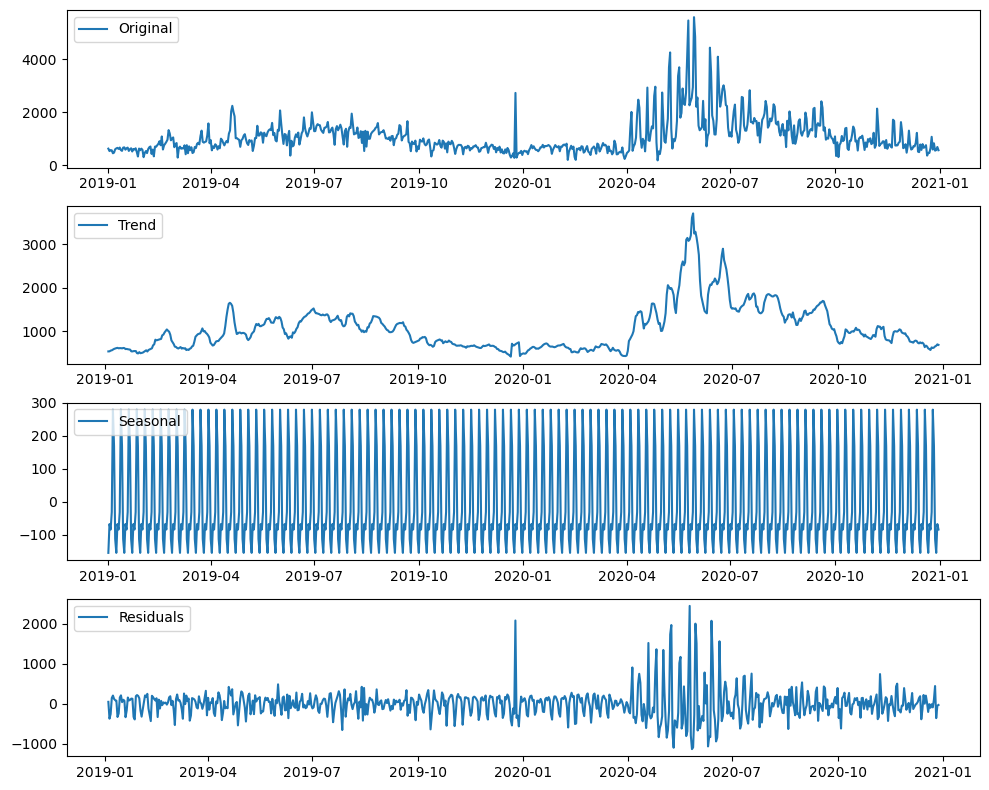

In [33]:
# Convert the index to datetime if needed
revenue_df.index = pd.to_datetime(revenue_df.index)

# Perform time series decomposition
decomposition = sm.tsa.seasonal_decompose(revenue_df['predicted_revenue_day'], model='additive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

# Plot original series
axes[0].plot(revenue_df.index, revenue_df['predicted_revenue_day'], label='Original')
axes[0].legend(loc='upper left')

# Plot trend component
axes[1].plot(revenue_df.index, decomposition.trend, label='Trend')
axes[1].legend(loc='upper left')

# Plot seasonal component
axes[2].plot(revenue_df.index, decomposition.seasonal, label='Seasonal')
axes[2].legend(loc='upper left')

# Plot residual component
axes[3].plot(revenue_df.index, decomposition.resid, label='Residuals')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

### Finding the value of d parameter

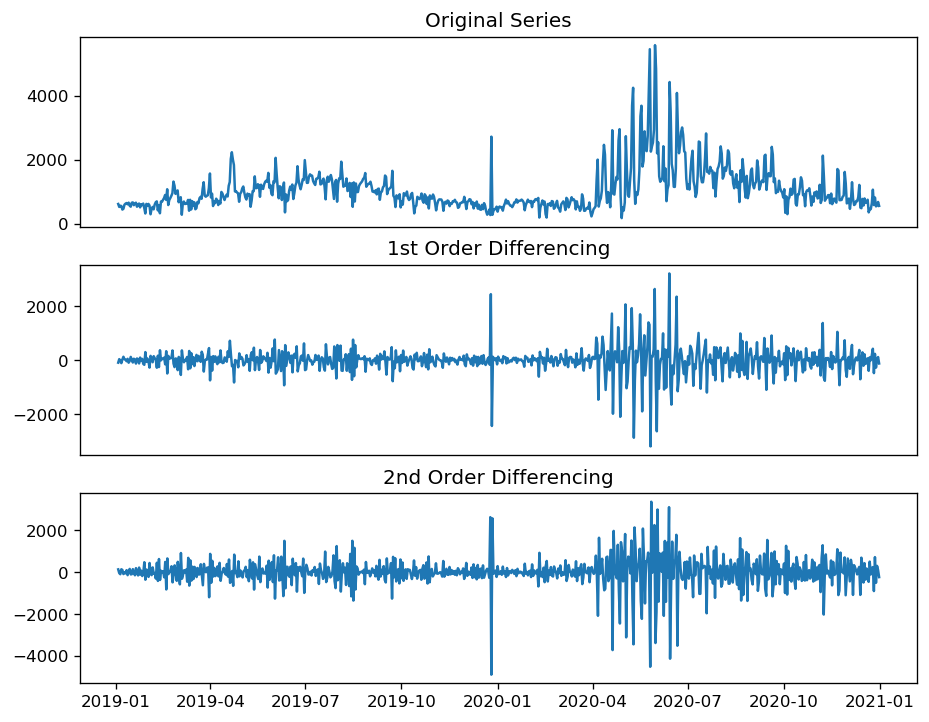

In [34]:
# Set figure size and DPI
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(revenue_df['predicted_revenue_day'])
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(revenue_df['predicted_revenue_day'].diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(revenue_df['predicted_revenue_day'].diff().diff())
ax3.set_title('2nd Order Differencing')

plt.show()

### Finding the values of p parameter

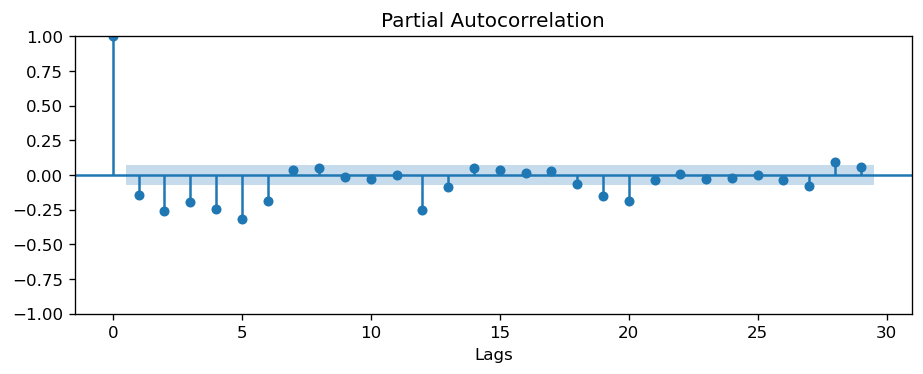

In [19]:
# Set figure size and DPI
plt.rcParams.update({'figure.figsize':(9, 3), 'figure.dpi':120})

# PACF plot of 1st differenced series
fig, ax = plt.subplots()
plot_pacf(revenue_df['predicted_revenue_day'].diff().dropna(), ax=ax)
ax.set_title('Partial Autocorrelation')
ax.set_xlabel('Lags')

plt.show()

### Finding the values of q parameter

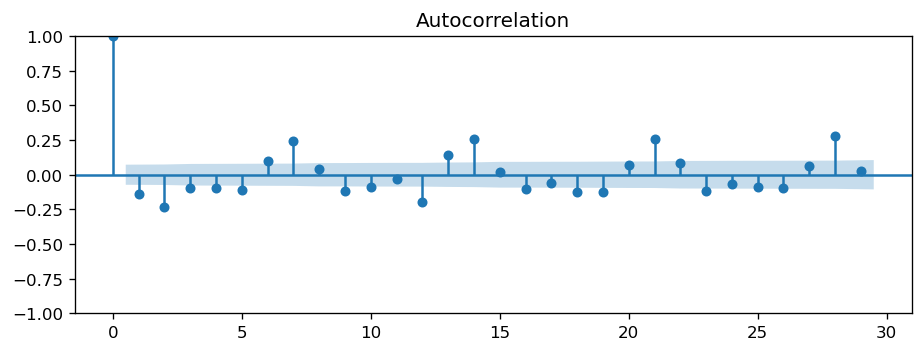

In [21]:
plt.rcParams.update({'figure.figsize':(9, 3), 'figure.dpi':120})

# PACF plot of 1st differenced series
fig, ax = plt.subplots()
plot_acf(revenue_df['predicted_revenue_day'].diff().dropna(), ax=ax)
ax.set_title('Autocorrelation')

plt.show()

#plot_acf(data.Passengers.diff().dropna())

### Hyper parameter tuning of the p,d and q parameters<a id="Hyper parameter tuning of the p,d and q parameters"></a>

In [38]:
p_values = [1,2,3,4,5,6]
q_values = [1,2]
d_values = [0,1,2]

In [ ]:
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.90)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # Make predictions
    predictions = list()
    test = test.reset_index(drop=True)  # Reset the index of the test set
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # Calculate out-of-sample error (RMSE)
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

warnings.filterwarnings("ignore")
evaluate_models(revenue_df['predicted_revenue_day'], p_values, d_values, q_values)

ARIMA(1, 0, 1) RMSE=335.366
ARIMA(1, 0, 2) RMSE=296.425
ARIMA(1, 1, 1) RMSE=310.365
ARIMA(1, 1, 2) RMSE=301.696
ARIMA(1, 2, 1) RMSE=363.952
ARIMA(1, 2, 2) RMSE=370.589
ARIMA(2, 0, 1) RMSE=330.837
ARIMA(2, 0, 2) RMSE=302.484
ARIMA(2, 1, 1) RMSE=302.020
ARIMA(2, 1, 2) RMSE=302.977
ARIMA(2, 2, 1) RMSE=334.478
ARIMA(2, 2, 2) RMSE=302.657
ARIMA(3, 0, 1) RMSE=302.820
ARIMA(3, 0, 2) RMSE=305.922
ARIMA(3, 1, 1) RMSE=304.285
ARIMA(3, 1, 2) RMSE=304.886
ARIMA(3, 2, 1) RMSE=336.617
ARIMA(3, 2, 2) RMSE=334.891
ARIMA(4, 0, 1) RMSE=305.660
ARIMA(4, 0, 2) RMSE=301.686
ARIMA(4, 1, 1) RMSE=298.732
ARIMA(4, 2, 1) RMSE=323.798
ARIMA(5, 0, 1) RMSE=299.219
ARIMA(5, 0, 2) RMSE=302.786
ARIMA(5, 1, 1) RMSE=293.933
ARIMA(5, 1, 2) RMSE=280.081
ARIMA(5, 2, 1) RMSE=302.230
ARIMA(5, 2, 2) RMSE=294.385
ARIMA(6, 0, 1) RMSE=293.603
ARIMA(6, 0, 2) RMSE=280.501
ARIMA(6, 1, 1) RMSE=290.804
ARIMA(6, 1, 2) RMSE=290.686
ARIMA(6, 2, 1) RMSE=290.797


### Best ARIMA model
Parameter: p=6,d=0, q=2

In [26]:
# Calculate the split index
split_index = int(len(revenue_df) * 0.9)

# Split the data into training and test sets
train_data = revenue_df.iloc[:split_index]
test_data = revenue_df.iloc[split_index:]

# Fit ARIMA model on training data
model = ARIMA(train_data['predicted_revenue_day'], order=(6, 0, 2))
results = model.fit()

# Print summary
print(results.summary())


                                 SARIMAX Results                                 
Dep. Variable:     predicted_revenue_day   No. Observations:                  657
Model:                    ARIMA(6, 0, 2)   Log Likelihood               -4890.735
Date:                   Wed, 24 Apr 2024   AIC                           9801.471
Time:                           20:34:25   BIC                           9846.348
Sample:                       01-01-2019   HQIC                          9818.869
                            - 10-18-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1088.8816    232.949      4.674      0.000     632.310    1545.453
ar.L1          1.7260      0.039     43.820      0.000       1.649       1.803
ar.L2         -1.5139      0

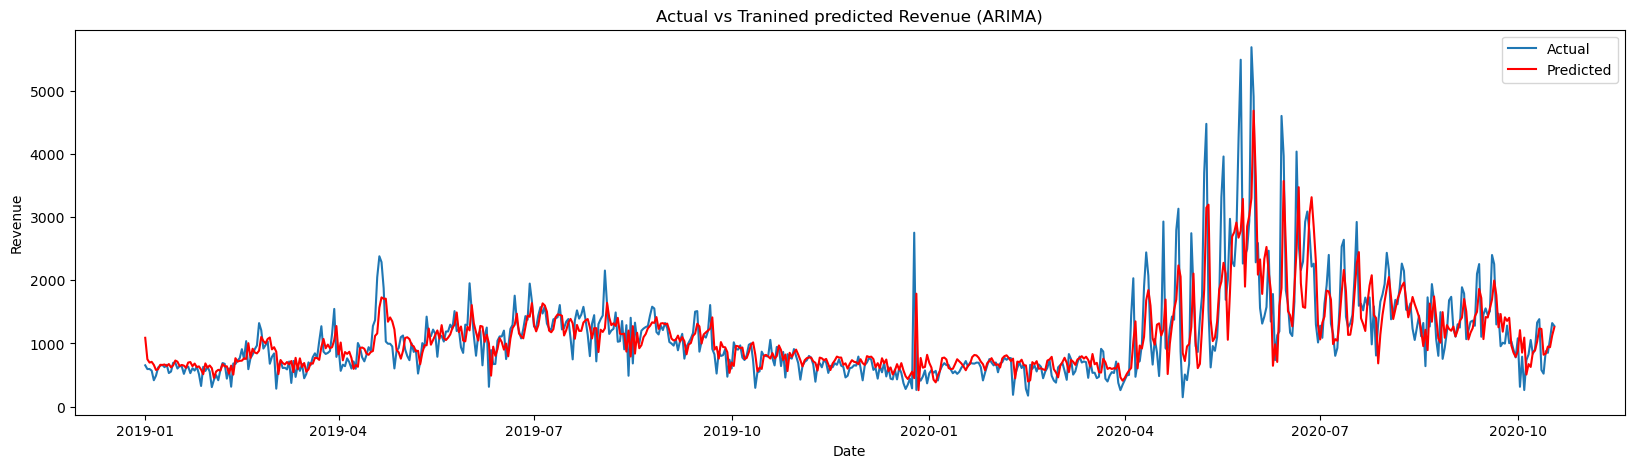

In [21]:
#Get the predicted values from the fitted model
predicted_values = results.predict()

# Plot actual vs predicted values
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['actual_revenue_day'], label='Actual')
plt.plot(train_data.index, predicted_values, color='red', label='Predicted')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs predicted Revenue of Training data (ARIMA)')
plt.legend()

# Show plot
plt.show()

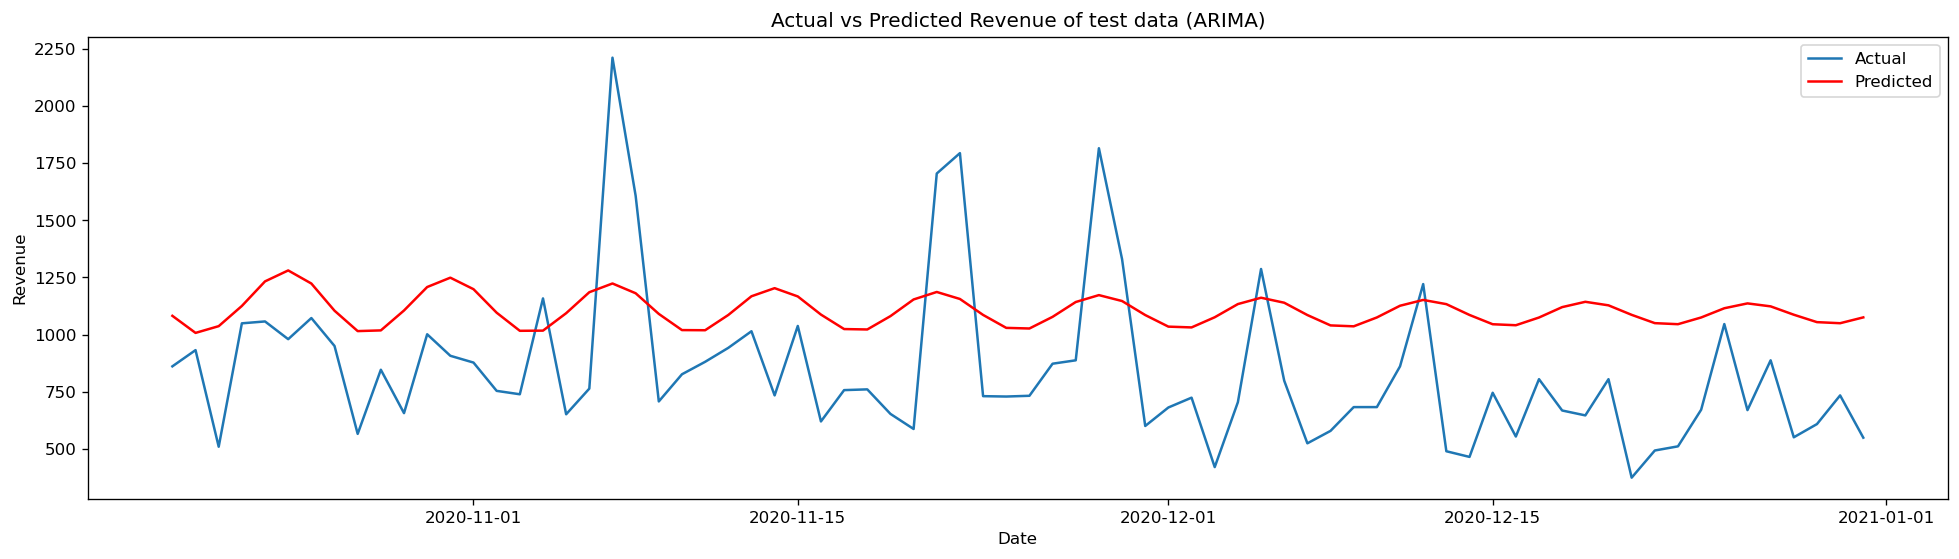

In [55]:
# Forecast future values for the test data
test_forecast_arima = len(test_data)
test_results_arima = results.forecast(steps=test_forecast_arima)

# Plot actual vs predicted values for the test data
plt.figure(figsize=(20, 5))
plt.plot(test_data.index, test_data['actual_revenue_day'], label='Actual')
plt.plot(test_data.index, test_results_arima, color='red', label='Predicted')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue of test data (ARIMA)')
plt.legend()

# Show plot
plt.show()

In [28]:
# Calculate RMSE between forecasted values and test data
rmse = np.sqrt(mean_squared_error(test_data['actual_revenue_day'], test_results_arima[:len(test_data)]))
print("RMSE between predicted values and test data:", rmse)

RMSE between predicted values and test data: 403.6907680748931


### Forecasting using the ARIMA model<a id="Forecasting using the ARIMA model"></a>

In [58]:
# Forecast future values beyond the test data
forecast_steps = 100  # Forecast for 100 more days
forecast_arima = results.forecast(steps=len(test_data) + forecast_steps)

# Print the forecasted values
print("Forecasted values: (ARIMA)")
print(forecast_arima)


Forecasted values: (ARIMA)
2020-10-19    1082.179890
2020-10-20    1007.556240
2020-10-21    1037.036864
2020-10-22    1125.378702
2020-10-23    1232.835623
                 ...     
2021-04-06    1083.717002
2021-04-07    1081.204483
2021-04-08    1084.439346
2021-04-09    1090.841976
2021-04-10    1095.589381
Freq: D, Name: predicted_mean, Length: 174, dtype: float64


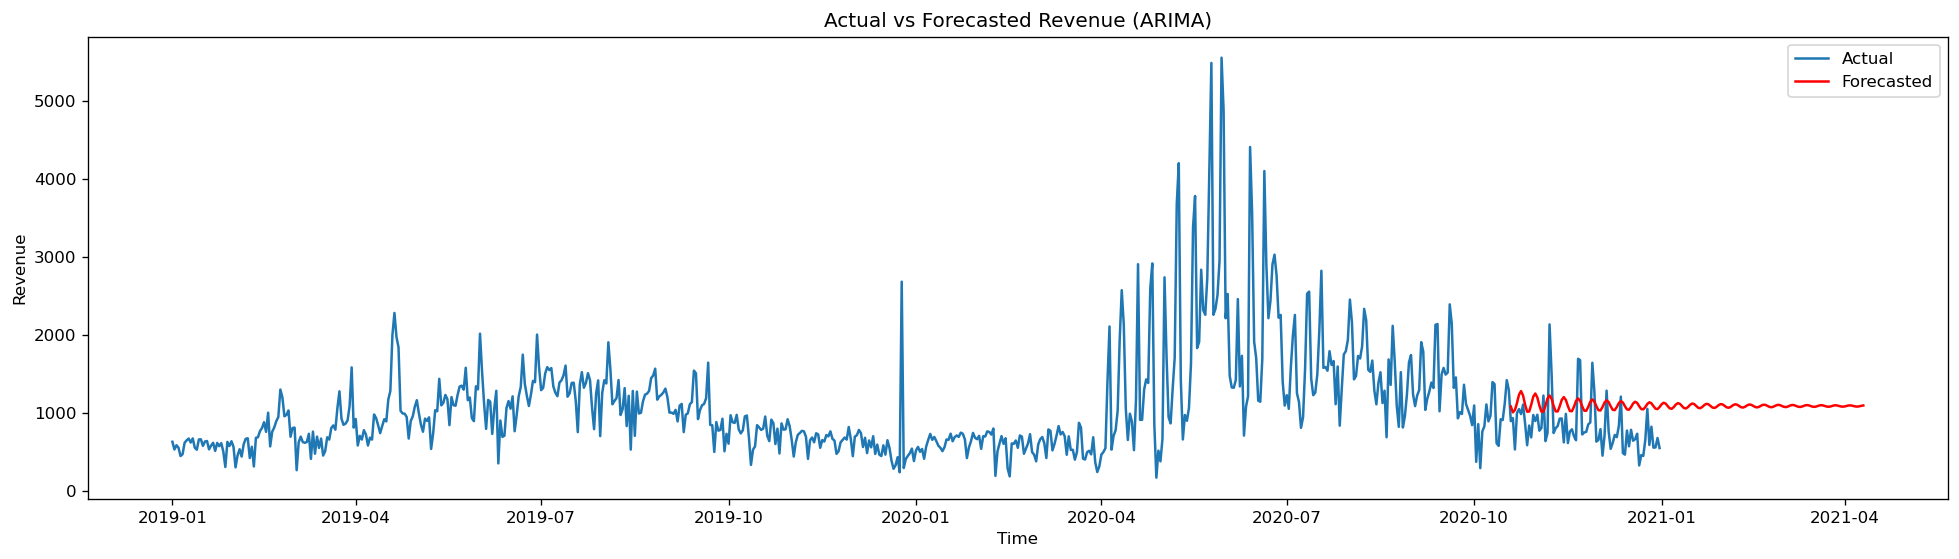

In [59]:
# Plot actual values
plt.figure(figsize=(20,5))
plt.plot(revenue_df['predicted_revenue_day'], label='Actual')

# Forecast for the next 50 steps
forecast_values = results.forecast(steps=50)

# Plot forecasted values
plt.plot(forecast.index, forecast_arima, color='red', label='Forecasted')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Forecasted Revenue (ARIMA)')
plt.legend()

# Show plot
plt.show()

## SARIMA - Seasonal Autoregressive Integrated Moving Average model<a id="SARIMA - Seasonal Autoregressive Integrated Moving Average model"></a>

### Finding the Seasonal component

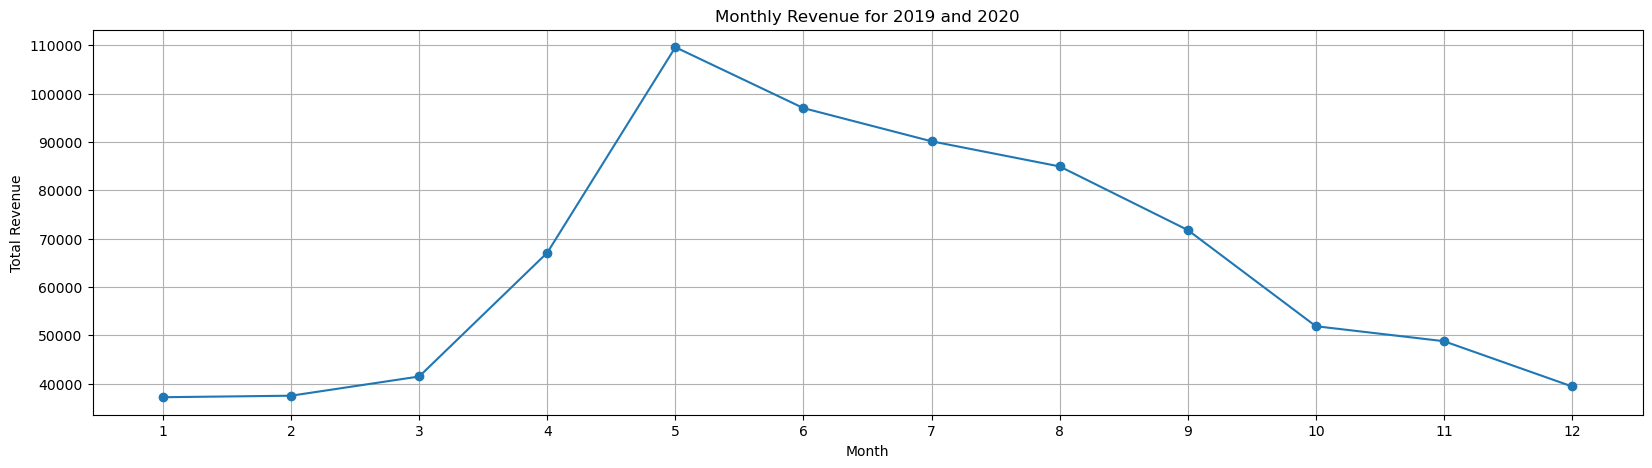

In [31]:
grouped_result.createOrReplaceTempView("revenue_table")
monthly_revenue = spark.sql("""
    SELECT month(date) as month, sum(actual_revenue_day) as total_revenue
    FROM revenue_table
    GROUP BY month(date)
    ORDER BY month
""")
# Convert Spark DataFrame to Pandas DataFrame for plotting
monthly_revenue_pd = monthly_revenue.toPandas()

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(monthly_revenue_pd["month"], monthly_revenue_pd["total_revenue"], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Monthly Revenue for 2019 and 2020')
plt.xticks(monthly_revenue_pd["month"])
plt.grid(True)
plt.show()


#### Hyper parameter tuning of p, d, q, P, D and Q parameters<a id="Hyper parameter tuning of p, d, q, P, D and Q parameters"></a>

In [ ]:
# Define TimeSeriesSplit with n_splits=10 for 90:10 split
tscv = TimeSeriesSplit(n_splits=10)

# Iterate over the splits
for train_index, test_index in tscv.split(revenue_df):
    # Get the 90% training data and 10% test data
    train_size = int(len(revenue_df) * 0.9)
    train, test = revenue_df.iloc[:train_size], revenue_df.iloc[train_size:]

    # Your code to train and test models goes here
    break  # Just using the first split for demonstration purposes



In [40]:
# Define the parameter grids
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s_values = [12]

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

# Initialize SARIMAX model
sarimax = sm.tsa.statespace.SARIMAX(revenue_df['predicted_revenue_day'])

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

best_mse = float('inf')
best_model_params = None

for params in param_grid:
    p, d, q, P, D, Q, s = params
    model = sm.tsa.statespace.SARIMAX(train['predicted_revenue_day'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    fit_model = model.fit()
    predictions = fit_model.predict(start=test.index[0], end=test.index[-1])
    mse = mean_squared_error(test['predicted_revenue_day'], predictions)
    rmse = np.sqrt(mse)
    print(f"Parameters: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}, RMSE={rmse}")
    if mse < best_mse:
        best_mse = mse
        best_model_params = params



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57785D+00    |proj g|=  3.55271D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.553D-10   8.578D+00
  F =   8.5778474169783951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=0, P=0, D=0, Q=0, s=12, RMSE=888.2168111530342
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.37934D+00    |proj g|=  3.74842D-03

At iterate   15    f=  8.37631D+00    |proj g|=  5.19502D-02

At iterate   20    f=  8.30523D+00    |proj g|=  1.37616D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     24      1     0     0   1.836D-06   8.305D+00
  F =   8.3050881369719001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=0, P=0, D=0, Q=1, s=12, RMSE=830.981554406333
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   4.647D-07   7.894D+00
  F =   7.8942533973003810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=0, P=0, D=1, Q=0, s=12, RMSE=466.4429930624181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72281D+00    |proj g|=  4.40777D-02

At iterate    5    f=  7.71756D+00    |proj g|=  2.97632D-04

At iterate   10    f=  7.71740D+00    |proj g|=  9.09182D-03

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31818D+00    |proj g|=  9.36968D-01

At iterate    5    f=  7.86125D+00    |proj g|=  2.54773D-02

At iterate   10    f=  7.85833D+00    |proj g|=  2.11994D-04

At iterate   15    f=  7.85797D+00    |proj g|=  4.64421D-03

At iterate   20    f=  7.85497D+00    |proj g|=  6.46746D-03

At iterate   25    f=  7.85286D+00    |proj g|=  2.20348D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   

 This problem is unconstrained.


Parameters: p=0, d=0, q=0, P=1, D=1, Q=0, s=12, RMSE=409.53626812581734
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71806D+00    |proj g|=  5.53780D-02


 This problem is unconstrained.



At iterate    5    f=  7.70766D+00    |proj g|=  2.16878D-04

At iterate   10    f=  7.70759D+00    |proj g|=  2.98083D-03

At iterate   15    f=  7.70477D+00    |proj g|=  3.25288D-02

At iterate   20    f=  7.70173D+00    |proj g|=  4.98446D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   4.984D-06   7.702D+00
  F =   7.7017311022362254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=0, P=1, D=1, Q=1, s=12, RMSE=480.4847450897606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =    

 This problem is unconstrained.


Parameters: p=0, d=0, q=1, P=0, D=0, Q=0, s=12, RMSE=883.3659487845007
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23970D+00    |proj g|=  1.90323D-01


 This problem is unconstrained.



At iterate    5    f=  8.20580D+00    |proj g|=  4.63348D-03

At iterate   10    f=  8.20566D+00    |proj g|=  5.49412D-03

At iterate   15    f=  8.19425D+00    |proj g|=  7.45565D-02

At iterate   20    f=  8.02037D+00    |proj g|=  1.53795D-01

At iterate   25    f=  8.00072D+00    |proj g|=  6.18261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     33      1     0     0   4.622D-06   8.001D+00
  F =   8.0007159212682897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=1, P=0, D=0, Q=1, s=12, RMSE=836.8830077701618
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.


Parameters: p=0, d=0, q=1, P=0, D=1, Q=0, s=12, RMSE=481.80721302743433
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58275D+00    |proj g|=  4.08716D-03


 This problem is unconstrained.



At iterate    5    f=  7.58265D+00    |proj g|=  1.30831D-03

At iterate   10    f=  7.58044D+00    |proj g|=  3.30184D-02

At iterate   15    f=  7.52961D+00    |proj g|=  2.35003D-02

At iterate   20    f=  7.52874D+00    |proj g|=  9.05507D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   9.055D-06   7.529D+00
  F =   7.5287413402423740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=1, P=0, D=1, Q=1, s=12, RMSE=581.0056749199376
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =    

 This problem is unconstrained.



At iterate   10    f=  8.16168D+00    |proj g|=  6.60213D-03

At iterate   15    f=  8.13630D+00    |proj g|=  4.82499D-02

At iterate   20    f=  7.87124D+00    |proj g|=  8.10863D-02

At iterate   25    f=  7.84197D+00    |proj g|=  1.74145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     33      1     0     0   1.268D-06   7.842D+00
  F =   7.8419733498833466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=1, P=1, D=0, Q=0, s=12, RMSE=564.6503392446311
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f=  8.12910D+00    |proj g|=  1.07056D-03

At iterate   10    f=  8.12812D+00    |proj g|=  2.26191D-03
  ys=-9.139E-03  -gs= 9.262E-03 BFGS update SKIPPED

At iterate   15    f=  7.91277D+00    |proj g|=  3.67332D-02

At iterate   20    f=  7.84251D+00    |proj g|=  9.00935D-02

At iterate   25    f=  7.76620D+00    |proj g|=  3.40844D-02

At iterate   30    f=  7.71544D+00    |proj g|=  4.14875D-03

At iterate   35    f=  7.71534D+00    |proj g|=  2.52815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     82      1     1     0   2.528D-04   7.715D+00
  F =   7.7153416330409756     

 This problem is unconstrained.



At iterate    5    f=  7.63989D+00    |proj g|=  1.05195D-03

At iterate   10    f=  7.63934D+00    |proj g|=  2.11145D-02

At iterate   15    f=  7.62265D+00    |proj g|=  8.21593D-02

At iterate   20    f=  7.61733D+00    |proj g|=  3.25517D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   3.255D-07   7.617D+00
  F =   7.6173348561950771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=1, P=1, D=1, Q=0, s=12, RMSE=412.3990875682257
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f=  7.57950D+00    |proj g|=  5.95516D-04

At iterate   10    f=  7.57934D+00    |proj g|=  4.69787D-03

At iterate   15    f=  7.56613D+00    |proj g|=  4.24368D-02

At iterate   20    f=  7.54853D+00    |proj g|=  5.16782D-02

At iterate   25    f=  7.52670D+00    |proj g|=  4.59865D-02

At iterate   30    f=  7.52390D+00    |proj g|=  1.77174D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     38      1     0     0   1.772D-06   7.524D+00
  F =   7.5239003574985954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=0, q=1, P=1, D=1, Q=1, s=12, RMS

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.60029D+00    |proj g|=  7.18365D-03

At iterate   10    f=  7.59846D+00    |proj g|=  1.30944D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     18      1     0     0   4.933D-06   7.598D+00
  F =   7.5983628970309756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=0, P=0, D=0, Q=1, s=12, RMSE=513.0229651494515
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91031D+00    |proj g|=  2.58371D-05

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.59801D+00    |proj g|=  6.51304D-04

At iterate   10    f=  7.51767D+00    |proj g|=  3.94351D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     15      1     0     0   3.944D-07   7.518D+00
  F =   7.5176718397623583     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=0, P=0, D=1, Q=1, s=12, RMSE=665.9434415679352
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60140D+00    |proj g|=  3.27122D-03

 This problem is unconstrained.



At iterate   10    f=  7.60131D+00    |proj g|=  2.18096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     17      1     0     0   5.134D-06   7.601D+00
  F =   7.6013125662227043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=0, P=1, D=0, Q=0, s=12, RMSE=517.5711776472606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60807D+00    |proj g|=  5.88208D-02


 This problem is unconstrained.



At iterate    5    f=  7.60078D+00    |proj g|=  5.93472D-02

At iterate   10    f=  7.59876D+00    |proj g|=  1.38501D-04

At iterate   15    f=  7.59866D+00    |proj g|=  3.22205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   4.582D-03   7.598D+00
  F =   7.5983595283920264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=0, d=1, q=0, P=1, D=0, Q=1, s=12, RMSE=513.5595396251393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.


Parameters: p=0, d=1, q=0, P=1, D=1, Q=0, s=12, RMSE=1299.3606533474326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63779D+00    |proj g|=  1.56348D-01


 This problem is unconstrained.



At iterate    5    f=  7.55719D+00    |proj g|=  2.61521D-03

At iterate   10    f=  7.55577D+00    |proj g|=  1.15124D-03

At iterate   15    f=  7.50053D+00    |proj g|=  4.62381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   1.804D-07   7.501D+00
  F =   7.5005260126085114     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=0, P=1, D=1, Q=1, s=12, RMSE=606.2291360510615
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.


Parameters: p=0, d=1, q=1, P=0, D=0, Q=0, s=12, RMSE=473.7361144103218
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58623D+00    |proj g|=  9.09708D-02


 This problem is unconstrained.



At iterate    5    f=  7.57759D+00    |proj g|=  2.43020D-03

At iterate   10    f=  7.57694D+00    |proj g|=  1.72973D-04

At iterate   15    f=  7.57690D+00    |proj g|=  6.92246D-03

At iterate   20    f=  7.57644D+00    |proj g|=  2.27243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   2.468D-05   7.576D+00
  F =   7.5764171999384491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=0, d=1, q=1, P=0, D=0, Q=1, s=12, RMSE=437.5214692878501


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88142D+00    |proj g|=  6.69570D-02

At iterate    5    f=  7.86255D+00    |proj g|=  5.52413D-05

At iterate   10    f=  7.86253D+00    |proj g|=  1.65233D-03

At iterate   15    f=  7.86211D+00    |proj g|=  1.53274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     19      1     0     0   2.677D-06   7.862D+00
  F =   7.8620930960718125     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Paramete

 This problem is unconstrained.



At iterate    5    f=  7.62076D+00    |proj g|=  7.67286D-04

At iterate   10    f=  7.58014D+00    |proj g|=  7.62989D-02

At iterate   15    f=  7.48413D+00    |proj g|=  9.81651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   5.991D-06   7.483D+00
  F =   7.4833322723448648     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=1, P=0, D=1, Q=1, s=12, RMSE=547.1134718154217
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate   10    f=  7.58049D+00    |proj g|=  8.83407D-04

At iterate   15    f=  7.58026D+00    |proj g|=  9.64812D-03

At iterate   20    f=  7.58013D+00    |proj g|=  4.87583D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   4.876D-06   7.580D+00
  F =   7.5801257361729988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=1, P=1, D=0, Q=0, s=12, RMSE=434.9746890511316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  7.57699D+00    |proj g|=  4.07665D-02

At iterate   10    f=  7.57597D+00    |proj g|=  2.81725D-04

At iterate   15    f=  7.57596D+00    |proj g|=  8.87192D-04

At iterate   20    f=  7.57578D+00    |proj g|=  4.32356D-03

At iterate   25    f=  7.57540D+00    |proj g|=  7.61885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   1.814D-06   7.575D+00
  F =   7.5753950670675145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=1, P=1, D=0, Q=1, s=12, RMSE=449.9650633216655
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.75343D+00    |proj g|=  3.47489D-04

At iterate   10    f=  7.75322D+00    |proj g|=  6.22318D-03

At iterate   15    f=  7.73249D+00    |proj g|=  1.02339D-02

At iterate   20    f=  7.72779D+00    |proj g|=  9.09647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   5.794D-07   7.728D+00
  F =   7.7277824737836456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=1, P=1, D=1, Q=0, s=12, RMSE=520.7322765158461
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f=  7.61679D+00    |proj g|=  6.27538D-03

At iterate   10    f=  7.61537D+00    |proj g|=  1.52854D-03

At iterate   15    f=  7.60585D+00    |proj g|=  1.36051D-02

At iterate   20    f=  7.47930D+00    |proj g|=  7.01530D-02

At iterate   25    f=  7.47157D+00    |proj g|=  6.97028D-04

At iterate   30    f=  7.47140D+00    |proj g|=  1.33805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     34      1     0     0   7.969D-06   7.471D+00
  F =   7.4714017049802663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=0, d=1, q=1, P=1, D=1, Q=1, s=12, RMS

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.59959D+00    |proj g|=  2.12719D-02

At iterate   10    f=  7.59889D+00    |proj g|=  1.02919D-04

At iterate   15    f=  7.59886D+00    |proj g|=  8.63457D-04

At iterate   20    f=  7.59868D+00    |proj g|=  1.69419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   9.215D-06   7.599D+00
  F =   7.5986791805342033     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=0, P=0, D=0, Q=1, s=12, RMSE=689.1671853420131
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.54833D+00    |proj g|=  1.89579D-03

At iterate   10    f=  7.54707D+00    |proj g|=  2.73981D-03

At iterate   15    f=  7.46430D+00    |proj g|=  1.48698D-02

At iterate   20    f=  7.46136D+00    |proj g|=  6.72085D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   6.721D-07   7.461D+00
  F =   7.4613641408972224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=0, P=0, D=1, Q=1, s=12, RMSE=419.004321214382
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =     

 This problem is unconstrained.



At iterate    5    f=  7.60064D+00    |proj g|=  3.45201D-03

At iterate   10    f=  7.60036D+00    |proj g|=  5.97516D-05

At iterate   15    f=  7.60034D+00    |proj g|=  1.41574D-03

At iterate   20    f=  7.60019D+00    |proj g|=  1.13037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   1.692D-06   7.600D+00
  F =   7.6001943427628875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=0, P=1, D=0, Q=0, s=12, RMSE=697.8058242095824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f=  7.60727D+00    |proj g|=  1.80297D-02

At iterate   10    f=  7.60033D+00    |proj g|=  9.34273D-03

At iterate   15    f=  7.59137D+00    |proj g|=  3.49630D-03

At iterate   20    f=  7.59010D+00    |proj g|=  1.39720D-03

At iterate   25    f=  7.58999D+00    |proj g|=  6.31580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   6.316D-04   7.590D+00
  F =   7.5899922775110653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=1, d=0, q=0, P=1, D=0, Q=1, s=12, RMSE=419.8331833762033
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.63994D+00    |proj g|=  1.39507D-03

At iterate   10    f=  7.63750D+00    |proj g|=  3.23327D-02

At iterate   15    f=  7.61763D+00    |proj g|=  1.53477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   5.598D-07   7.618D+00
  F =   7.6176294536704248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=0, P=1, D=1, Q=0, s=12, RMSE=428.6034052536823
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  7.54434D+00    |proj g|=  3.53073D-03

At iterate   10    f=  7.54397D+00    |proj g|=  1.33698D-03

At iterate   15    f=  7.54191D+00    |proj g|=  6.94746D-03

At iterate   20    f=  7.45948D+00    |proj g|=  4.18526D-02

At iterate   25    f=  7.45588D+00    |proj g|=  1.61306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   6.592D-06   7.456D+00
  F =   7.4558772044815589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=0, P=1, D=1, Q=1, s=12, RMSE=419.8373025966016
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   20    f=  7.59973D+00    |proj g|=  1.00586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   7.220D-06   7.600D+00
  F =   7.5997259527098491     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=1, P=0, D=0, Q=0, s=12, RMSE=531.4330313322225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61754D+00    |proj g|=  2.12802D-01


 This problem is unconstrained.



At iterate    5    f=  7.58888D+00    |proj g|=  2.10562D-02

At iterate   10    f=  7.58586D+00    |proj g|=  4.79667D-04

At iterate   15    f=  7.58585D+00    |proj g|=  1.07726D-03

At iterate   20    f=  7.58550D+00    |proj g|=  7.45381D-03

At iterate   25    f=  7.58537D+00    |proj g|=  3.37650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   3.376D-05   7.585D+00
  F =   7.5853678270755509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=1, d=0, q=1, P=0, D=0, Q=1, s=12, RMSE=474.2396239453014
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   9.401D-06   7.761D+00
  F =   7.7606281295937407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=1, P=0, D=1, Q=0, s=12, RMSE=484.80411126785356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56471D+00    |proj g|=  8.91021D-02


 This problem is unconstrained.



At iterate    5    f=  7.54501D+00    |proj g|=  5.01017D-03

At iterate   10    f=  7.54377D+00    |proj g|=  1.41857D-03

At iterate   15    f=  7.48251D+00    |proj g|=  1.10943D-02

At iterate   20    f=  7.46412D+00    |proj g|=  5.30785D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   4.006D-06   7.461D+00
  F =   7.4612573551107104     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=1, P=0, D=1, Q=1, s=12, RMSE=419.4267412835755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f=  7.60343D+00    |proj g|=  7.38916D-02

At iterate   10    f=  7.58990D+00    |proj g|=  2.83791D-03

At iterate   15    f=  7.58915D+00    |proj g|=  4.08082D-03

At iterate   20    f=  7.58914D+00    |proj g|=  2.45804D-04

At iterate   25    f=  7.58906D+00    |proj g|=  3.92372D-03

At iterate   30    f=  7.58880D+00    |proj g|=  3.92202D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     36      1     0     0   9.027D-07   7.589D+00
  F =   7.5887959363627155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=1, P=1, D=0, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.60030D+00    |proj g|=  1.60616D-03

At iterate   10    f=  7.59817D+00    |proj g|=  8.23936D-03

At iterate   15    f=  7.59520D+00    |proj g|=  5.21966D-03

At iterate   20    f=  7.59013D+00    |proj g|=  2.34207D-03

At iterate   25    f=  7.58954D+00    |proj g|=  3.97243D-04

At iterate   30    f=  7.58952D+00    |proj g|=  1.19237D-04

At iterate   35    f=  7.58951D+00    |proj g|=  1.49654D-03

At iterate   40    f=  7.58913D+00    |proj g|=  6.42152D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  7.58874D+00    |proj g|=  1.32708D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     83      2     0     0   6.549D-05   7.589D+00
  F =   7.5887407593722891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=1, d=0, q=1, P=1, D=0, Q=1, s=12, RMSE=400.0454110687334
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62877D+00    |proj g|=  5.19492D-02


 This problem is unconstrained.



At iterate    5    f=  7.62493D+00    |proj g|=  8.47056D-04

At iterate   10    f=  7.62490D+00    |proj g|=  3.53952D-03

At iterate   15    f=  7.62130D+00    |proj g|=  4.53641D-02

At iterate   20    f=  7.60009D+00    |proj g|=  1.04175D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   9.081D-07   7.600D+00
  F =   7.5999363830953861     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=1, P=1, D=1, Q=0, s=12, RMSE=418.022147611011
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =     

 This problem is unconstrained.



At iterate    5    f=  7.54165D+00    |proj g|=  1.70276D-02

At iterate   10    f=  7.53998D+00    |proj g|=  1.11787D-03

At iterate   15    f=  7.53874D+00    |proj g|=  1.08805D-02

At iterate   20    f=  7.45600D+00    |proj g|=  2.07778D-02

At iterate   25    f=  7.45541D+00    |proj g|=  8.66187D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   6.730D-06   7.455D+00
  F =   7.4554058463731652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=0, q=1, P=1, D=1, Q=1, s=12, RMSE=420.8206012869592
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   8.248D-05   7.590D+00
  F =   7.5902220077173439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=1, d=1, q=0, P=0, D=0, Q=1, s=12, RMSE=519.6001669414111
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89731D+00    |proj g|=  4.17446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of 

 This problem is unconstrained.
 This problem is unconstrained.


Parameters: p=1, d=1, q=0, P=0, D=1, Q=0, s=12, RMSE=2276.403603899599
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64954D+00    |proj g|=  2.20724D-02

At iterate    5    f=  7.64035D+00    |proj g|=  7.72613D-04

At iterate   10    f=  7.51460D+00    |proj g|=  6.91069D-02

At iterate   15    f=  7.50797D+00    |proj g|=  4.27089D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     23      1     0     0   4.271D-06   7.508D+00
  F =   7.5079674270692580     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60029D+00    |proj g|=  4.83214D-02

At iterate    5    f=  7.59130D+00    |proj g|=  4.23132D-02


 This problem is unconstrained.



At iterate   10    f=  7.58980D+00    |proj g|=  8.80185D-05

At iterate   15    f=  7.58979D+00    |proj g|=  3.39311D-03

At iterate   20    f=  7.58943D+00    |proj g|=  1.11390D-02

At iterate   25    f=  7.58935D+00    |proj g|=  9.00561D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   8.742D-06   7.589D+00
  F =   7.5893520492452469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=0, P=1, D=0, Q=1, s=12, RMSE=525.0176385848298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =    

 This problem is unconstrained.



At iterate    5    f=  7.75994D+00    |proj g|=  3.64277D-04

At iterate   10    f=  7.75970D+00    |proj g|=  1.10075D-02

At iterate   15    f=  7.74152D+00    |proj g|=  7.19361D-02

At iterate   20    f=  7.73536D+00    |proj g|=  1.43498D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   8.103D-07   7.735D+00
  F =   7.7353619871360761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=0, P=1, D=1, Q=0, s=12, RMSE=1341.8327929912998
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =   

 This problem is unconstrained.



At iterate    5    f=  7.63338D+00    |proj g|=  6.42205D-03

At iterate   10    f=  7.63291D+00    |proj g|=  1.12292D-03

At iterate   15    f=  7.63015D+00    |proj g|=  1.86559D-02

At iterate   20    f=  7.49233D+00    |proj g|=  1.08644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   4.948D-06   7.492D+00
  F =   7.4921071386662348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=0, P=1, D=1, Q=1, s=12, RMSE=623.2024991293767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =    

 This problem is unconstrained.



At iterate   15    f=  7.50733D+00    |proj g|=  3.48378D-03

At iterate   20    f=  7.50584D+00    |proj g|=  3.07368D-02

At iterate   25    f=  7.50314D+00    |proj g|=  1.16837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   2.101D-05   7.503D+00
  F =   7.5031361328879802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=1, d=1, q=1, P=0, D=0, Q=0, s=12, RMSE=414.4808610851895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  7.49778D+00    |proj g|=  4.48322D-02

At iterate   10    f=  7.49475D+00    |proj g|=  4.76847D-03

At iterate   15    f=  7.49472D+00    |proj g|=  1.60248D-03

At iterate   20    f=  7.49430D+00    |proj g|=  2.08070D-02

At iterate   25    f=  7.48890D+00    |proj g|=  2.43940D-02

At iterate   30    f=  7.48845D+00    |proj g|=  3.51008D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     34      1     0     0   3.510D-06   7.488D+00
  F =   7.4884509622762785     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=1, P=0, D=0, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.77831D+00    |proj g|=  1.44948D-02

At iterate   10    f=  7.77326D+00    |proj g|=  1.22919D-03

At iterate   15    f=  7.76579D+00    |proj g|=  1.64536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   3.488D-06   7.764D+00
  F =   7.7637659939654782     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=1, P=0, D=1, Q=0, s=12, RMSE=518.3265124319053
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  7.57520D+00    |proj g|=  4.43341D-03

At iterate   10    f=  7.57354D+00    |proj g|=  1.51963D-03

At iterate   15    f=  7.40526D+00    |proj g|=  9.61968D-03

At iterate   20    f=  7.40305D+00    |proj g|=  2.62350D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   2.624D-06   7.403D+00
  F =   7.4030468160495451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=1, P=0, D=1, Q=1, s=12, RMSE=464.97056287492035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =   

 This problem is unconstrained.


At iterate    5    f=  7.49727D+00    |proj g|=  5.44089D-03

At iterate   10    f=  7.49657D+00    |proj g|=  3.08388D-04

At iterate   15    f=  7.49655D+00    |proj g|=  3.23218D-03

At iterate   20    f=  7.49471D+00    |proj g|=  3.04654D-02

At iterate   25    f=  7.49064D+00    |proj g|=  7.08075D-04

At iterate   30    f=  7.49063D+00    |proj g|=  4.68551D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     33      1     0     0   2.885D-06   7.491D+00
  F =   7.4906327417899510     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=1, P=1, D=0, Q=0, s=12, RMSE

 This problem is unconstrained.



At iterate    5    f=  7.50320D+00    |proj g|=  4.25937D-02

At iterate   10    f=  7.49519D+00    |proj g|=  1.74397D-02

At iterate   15    f=  7.49458D+00    |proj g|=  1.62741D-03

At iterate   20    f=  7.49454D+00    |proj g|=  3.12504D-03

At iterate   25    f=  7.49148D+00    |proj g|=  2.73692D-02

At iterate   30    f=  7.48830D+00    |proj g|=  9.39178D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     39      1     0     0   8.284D-06   7.488D+00
  F =   7.4882814411479615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=1, P=1, D=0, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.66840D+00    |proj g|=  7.66397D-03

At iterate   10    f=  7.66582D+00    |proj g|=  8.49517D-04

At iterate   15    f=  7.64357D+00    |proj g|=  7.28193D-02

At iterate   20    f=  7.61063D+00    |proj g|=  2.41124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   3.864D-07   7.611D+00
  F =   7.6105928778901593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=1, d=1, q=1, P=1, D=1, Q=0, s=12, RMSE=447.51454092166824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =   

 This problem is unconstrained.



At iterate    5    f=  7.56943D+00    |proj g|=  2.59239D-03

At iterate   10    f=  7.56906D+00    |proj g|=  9.59505D-04

At iterate   15    f=  7.56465D+00    |proj g|=  2.23460D-02

At iterate   20    f=  7.39227D+00    |proj g|=  1.25418D-02

At iterate   25    f=  7.38984D+00    |proj g|=  7.14722D-05

At iterate   30    f=  7.38984D+00    |proj g|=  2.34871D-04

At iterate   35    f=  7.38984D+00    |proj g|=  1.15612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     40      1     0     0   6.045D-06   7.390D+00
  F =   7.3898362063962209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.59372D+00    |proj g|=  1.62021D-02

At iterate   10    f=  7.59310D+00    |proj g|=  1.38488D-04

At iterate   15    f=  7.59310D+00    |proj g|=  1.92111D-03

At iterate   20    f=  7.59294D+00    |proj g|=  7.85513D-03

At iterate   25    f=  7.59284D+00    |proj g|=  1.61669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   1.617D-05   7.593D+00
  F =   7.5928444360835483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=0, q=0, P=0, D=0, Q=1, s=12, RMSE=630.0098465815937
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.


Parameters: p=2, d=0, q=0, P=0, D=1, Q=0, s=12, RMSE=478.32610995268533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56616D+00    |proj g|=  1.00598D-01


 This problem is unconstrained.



At iterate    5    f=  7.54448D+00    |proj g|=  7.96864D-03

At iterate   10    f=  7.54376D+00    |proj g|=  7.06831D-04

At iterate   15    f=  7.54309D+00    |proj g|=  8.40571D-03

At iterate   20    f=  7.46390D+00    |proj g|=  2.34329D-02

At iterate   25    f=  7.46130D+00    |proj g|=  2.75996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   1.376D-06   7.461D+00
  F =   7.4613034792136590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=0, q=0, P=0, D=1, Q=1, s=12, RMSE=419.2725844419249
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.59606D+00    |proj g|=  5.54872D-03

At iterate   10    f=  7.59531D+00    |proj g|=  5.56309D-05

At iterate   15    f=  7.59529D+00    |proj g|=  1.18591D-03

At iterate   20    f=  7.59513D+00    |proj g|=  8.96136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   8.086D-06   7.595D+00
  F =   7.5951242680804869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=0, q=0, P=1, D=0, Q=0, s=12, RMSE=648.5391398688895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =    

 This problem is unconstrained.



At iterate    5    f=  7.60646D+00    |proj g|=  7.66210D-03

At iterate   10    f=  7.60128D+00    |proj g|=  1.67475D-02

At iterate   15    f=  7.59602D+00    |proj g|=  4.02689D-02

At iterate   20    f=  7.59075D+00    |proj g|=  1.33783D-02

At iterate   25    f=  7.58992D+00    |proj g|=  1.20438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   3.421D-04   7.590D+00
  F =   7.5899135300310183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=0, q=0, P=1, D=0, Q=1, s=12, RMSE=436.00816258424163
RUNNING THE L-BFGS-B CODE

           * *

 This problem is unconstrained.



At iterate    5    f=  7.62130D+00    |proj g|=  6.41710D-04

At iterate   10    f=  7.62082D+00    |proj g|=  1.52990D-02

At iterate   15    f=  7.60700D+00    |proj g|=  9.17178D-02

At iterate   20    f=  7.59512D+00    |proj g|=  6.13070D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   9.912D-06   7.595D+00
  F =   7.5951214895905617     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=0, q=0, P=1, D=1, Q=0, s=12, RMSE=410.49795139057693
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =   

 This problem is unconstrained.



At iterate    5    f=  7.54028D+00    |proj g|=  1.23927D-02

At iterate   10    f=  7.53959D+00    |proj g|=  7.17277D-04

At iterate   15    f=  7.53926D+00    |proj g|=  1.09432D-02

At iterate   20    f=  7.50325D+00    |proj g|=  1.60219D-01

At iterate   25    f=  7.45566D+00    |proj g|=  3.54490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     32      1     0     0   2.359D-05   7.456D+00
  F =   7.4555835957725147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=0, q=0, P=1, D=1, Q=1, s=12, RMSE=421.2379674165105
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   15    f=  7.59523D+00    |proj g|=  1.02584D-01

At iterate   20    f=  7.53856D+00    |proj g|=  6.15232D-03

At iterate   25    f=  7.52886D+00    |proj g|=  4.34194D-03

At iterate   30    f=  7.51616D+00    |proj g|=  7.30357D-03

At iterate   35    f=  7.51580D+00    |proj g|=  1.74868D-03

At iterate   40    f=  7.51548D+00    |proj g|=  2.24553D-03

At iterate   45    f=  7.51540D+00    |proj g|=  1.31806D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     61      1     0     0   1.318D-07   7.515D+00
  F =   7.5153987384825003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  7.61185D+00    |proj g|=  6.37484D-02

At iterate   10    f=  7.59869D+00    |proj g|=  6.68353D-04
  ys=-1.192E-03  -gs= 1.279E-03 BFGS update SKIPPED

At iterate   15    f=  7.57713D+00    |proj g|=  9.09438D-02

At iterate   20    f=  7.51426D+00    |proj g|=  1.62383D-02

At iterate   25    f=  7.50794D+00    |proj g|=  6.41816D-04

At iterate   30    f=  7.50763D+00    |proj g|=  3.30142D-04

At iterate   35    f=  7.50486D+00    |proj g|=  2.18493D-02

At iterate   40    f=  7.50365D+00    |proj g|=  1.25016D-03
  ys=-7.378E-04  -gs= 6.340E-04 BFGS update SKIPPED

At iterate   45    f=  7.50249D+00    |proj g|=  2.57796D-02

At iterate   50    f=  7.50079D+00    |proj g|=  5.92839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg =

 This problem is unconstrained.



At iterate    5    f=  7.76062D+00    |proj g|=  3.17576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   9.397D-06   7.761D+00
  F =   7.7606173786800845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=0, q=1, P=0, D=1, Q=0, s=12, RMSE=484.0925240344147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56485D+00    |proj g|=  9.10646D-02


 This problem is unconstrained.



At iterate    5    f=  7.54490D+00    |proj g|=  9.45111D-03

At iterate   10    f=  7.54353D+00    |proj g|=  7.08911D-04

At iterate   15    f=  7.54318D+00    |proj g|=  7.29455D-03

At iterate   20    f=  7.54139D+00    |proj g|=  4.43388D-03

At iterate   25    f=  7.50685D+00    |proj g|=  1.99270D-02

At iterate   30    f=  7.46069D+00    |proj g|=  1.06122D-02

At iterate   35    f=  7.45926D+00    |proj g|=  5.82327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     56      1     0     0   4.184D-05   7.459D+00
  F =   7.4592639994527339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.87518D+00    |proj g|=  1.56673D-01

At iterate   10    f=  7.61363D+00    |proj g|=  1.24668D-01

At iterate   15    f=  7.60061D+00    |proj g|=  4.45246D-03

At iterate   20    f=  7.60043D+00    |proj g|=  2.74024D-04

At iterate   25    f=  7.60013D+00    |proj g|=  2.15689D-02

At iterate   30    f=  7.58648D+00    |proj g|=  9.88916D-02

At iterate   35    f=  7.53032D+00    |proj g|=  3.23686D-02

At iterate   40    f=  7.51265D+00    |proj g|=  1.01608D-02

At iterate   45    f=  7.51120D+00    |proj g|=  3.51468D-04

At iterate   50    f=  7.51109D+00    |proj g|=  3.06461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.60848D+00    |proj g|=  1.16890D-02

At iterate   10    f=  7.59911D+00    |proj g|=  9.48359D-03

At iterate   15    f=  7.58965D+00    |proj g|=  1.18647D-02

At iterate   20    f=  7.58812D+00    |proj g|=  6.47943D-03

At iterate   25    f=  7.58761D+00    |proj g|=  3.39123D-03

At iterate   30    f=  7.58755D+00    |proj g|=  1.48330D-03

At iterate   35    f=  7.58720D+00    |proj g|=  3.63845D-04

At iterate   40    f=  7.58719D+00    |proj g|=  2.26017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     57      1     0     0   2.260D-04   7.587D+00
  F =   7.58719414091

 This problem is unconstrained.



At iterate    5    f=  7.62352D+00    |proj g|=  1.51945D-02

At iterate   10    f=  7.62104D+00    |proj g|=  8.93276D-04

At iterate   15    f=  7.62099D+00    |proj g|=  3.71827D-03

At iterate   20    f=  7.61573D+00    |proj g|=  4.61779D-02

At iterate   25    f=  7.59442D+00    |proj g|=  2.17465D-03

At iterate   30    f=  7.59441D+00    |proj g|=  3.10954D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     32      1     0     0   3.110D-05   7.594D+00
  F =   7.5944148989981004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=0, q=1, P=1, D=1, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.54045D+00    |proj g|=  5.35933D-03

At iterate   10    f=  7.53956D+00    |proj g|=  1.05060D-03

At iterate   15    f=  7.53903D+00    |proj g|=  8.06166D-03

At iterate   20    f=  7.53765D+00    |proj g|=  8.22134D-03

At iterate   25    f=  7.48662D+00    |proj g|=  6.01410D-02

At iterate   30    f=  7.45200D+00    |proj g|=  1.09054D-02

At iterate   35    f=  7.45187D+00    |proj g|=  2.03562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     44      1     0     0   2.036D-04   7.452D+00
  F =   7.4518745316427610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.56213D+00    |proj g|=  7.15991D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   7.160D-05   7.562D+00
  F =   7.5621271866513551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=1, q=0, P=0, D=0, Q=1, s=12, RMSE=494.9174237699275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85479D+00    |proj g|=  4.52924D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   1.055D-05   7.855D+00
  F =   7.8547904634573991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=1, q=0, P=0, D=1, Q=0, s=12, RMSE=2573.0460280624175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61238D+00    |proj g|=  2.24461D-02


 This problem is unconstrained.



At iterate    5    f=  7.60284D+00    |proj g|=  1.58006D-03

At iterate   10    f=  7.60237D+00    |proj g|=  8.78190D-04

At iterate   15    f=  7.58559D+00    |proj g|=  1.33834D-01

At iterate   20    f=  7.47915D+00    |proj g|=  8.95387D-02

At iterate   25    f=  7.47533D+00    |proj g|=  9.60831D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   9.608D-07   7.475D+00
  F =   7.4753293595260244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=0, P=0, D=1, Q=1, s=12, RMSE=656.8840774450179
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.


Parameters: p=2, d=1, q=0, P=1, D=0, Q=0, s=12, RMSE=503.74756421574773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57138D+00    |proj g|=  2.34446D-02


 This problem is unconstrained.



At iterate    5    f=  7.56277D+00    |proj g|=  4.97470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   7.523D-05   7.561D+00
  F =   7.5612453406355078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=1, q=0, P=1, D=0, Q=1, s=12, RMSE=503.03831511272625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73548D+00    |proj g|=  1.10096D-01


 This problem is unconstrained.



At iterate    5    f=  7.72859D+00    |proj g|=  3.51681D-04

At iterate   10    f=  7.72853D+00    |proj g|=  5.53937D-03

At iterate   15    f=  7.72282D+00    |proj g|=  5.87003D-02

At iterate   20    f=  7.70794D+00    |proj g|=  2.96456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   3.582D-06   7.708D+00
  F =   7.7079389706456061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=0, P=1, D=1, Q=0, s=12, RMSE=1292.6833066736986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =   

 This problem is unconstrained.



At iterate    5    f=  7.59840D+00    |proj g|=  2.49807D-02

At iterate   10    f=  7.59674D+00    |proj g|=  7.52147D-04

At iterate   15    f=  7.58135D+00    |proj g|=  5.19595D-02

At iterate   20    f=  7.47212D+00    |proj g|=  1.20824D-01

At iterate   25    f=  7.46314D+00    |proj g|=  3.15211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   6.763D-07   7.463D+00
  F =   7.4631438801989880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=0, P=1, D=1, Q=1, s=12, RMSE=593.8553181628575
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   10    f=  7.49219D+00    |proj g|=  8.94995D-04

At iterate   15    f=  7.49200D+00    |proj g|=  1.60547D-02

At iterate   20    f=  7.48798D+00    |proj g|=  2.90085D-02

At iterate   25    f=  7.48708D+00    |proj g|=  2.07393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   1.986D-06   7.487D+00
  F =   7.4870804516760892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=1, P=0, D=0, Q=0, s=12, RMSE=390.0645488893451
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =    

 This problem is unconstrained.



At iterate    5    f=  7.47919D+00    |proj g|=  1.59913D-02

At iterate   10    f=  7.47843D+00    |proj g|=  3.49599D-04

At iterate   15    f=  7.47838D+00    |proj g|=  6.21083D-03

At iterate   20    f=  7.47395D+00    |proj g|=  4.73641D-02

At iterate   25    f=  7.47083D+00    |proj g|=  2.60422D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   7.733D-06   7.471D+00
  F =   7.4708331451626746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=1, P=0, D=0, Q=1, s=12, RMSE=387.7410973988542
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.78571D+00    |proj g|=  7.36465D-02

At iterate   10    f=  7.76599D+00    |proj g|=  2.35523D-02

At iterate   15    f=  7.76258D+00    |proj g|=  5.24775D-03

At iterate   20    f=  7.76222D+00    |proj g|=  2.31086D-04

At iterate   25    f=  7.75675D+00    |proj g|=  4.26621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   7.782D-06   7.754D+00
  F =   7.7541567739897879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=1, P=0, D=1, Q=0, s=12, RMSE=500.2407947990323
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.55853D+00    |proj g|=  5.69057D-03

At iterate   10    f=  7.55806D+00    |proj g|=  4.03460D-03

At iterate   15    f=  7.55686D+00    |proj g|=  8.99746D-03

At iterate   20    f=  7.45276D+00    |proj g|=  1.61115D-01

At iterate   25    f=  7.38728D+00    |proj g|=  1.87348D-02

At iterate   30    f=  7.38683D+00    |proj g|=  2.57160D-03

At iterate   35    f=  7.38662D+00    |proj g|=  8.75096D-04

At iterate   40    f=  7.38659D+00    |proj g|=  3.78527D-04

At iterate   45    f=  7.38659D+00    |proj g|=  1.13925D-04

At iterate   50    f=  7.38659D+00    |proj g|=  8.75244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.47986D+00    |proj g|=  1.86611D-02

At iterate   10    f=  7.47931D+00    |proj g|=  1.11797D-03

At iterate   15    f=  7.47869D+00    |proj g|=  2.58478D-02

At iterate   20    f=  7.47211D+00    |proj g|=  1.54740D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   2.298D-05   7.472D+00
  F =   7.4718931223502087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=2, d=1, q=1, P=1, D=0, Q=0, s=12, RMSE=379.82717362438444
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =   

 This problem is unconstrained.



At iterate    5    f=  7.47971D+00    |proj g|=  2.32527D-02

At iterate   10    f=  7.47851D+00    |proj g|=  5.20398D-03

At iterate   15    f=  7.47842D+00    |proj g|=  3.49530D-04

At iterate   20    f=  7.47837D+00    |proj g|=  4.85490D-03

At iterate   25    f=  7.47631D+00    |proj g|=  5.37042D-02

At iterate   30    f=  7.47214D+00    |proj g|=  2.27120D-02

At iterate   35    f=  7.47083D+00    |proj g|=  9.53499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   1.511D-05   7.471D+00
  F =   7.4708274026587613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.64605D+00    |proj g|=  5.39911D-03

At iterate   10    f=  7.64379D+00    |proj g|=  6.36815D-04

At iterate   15    f=  7.63768D+00    |proj g|=  4.85813D-02

At iterate   20    f=  7.58832D+00    |proj g|=  2.42654D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   2.295D-06   7.588D+00
  F =   7.5883130077408536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=2, d=1, q=1, P=1, D=1, Q=0, s=12, RMSE=427.9561852392837
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =    

 This problem is unconstrained.



At iterate    5    f=  7.55464D+00    |proj g|=  8.32164D-03

At iterate   10    f=  7.55123D+00    |proj g|=  8.47301D-04

At iterate   15    f=  7.55081D+00    |proj g|=  9.01826D-03

At iterate   20    f=  7.52660D+00    |proj g|=  9.14097D-02

At iterate   25    f=  7.44676D+00    |proj g|=  5.83049D-02

At iterate   30    f=  7.38509D+00    |proj g|=  1.23592D-01

At iterate   35    f=  7.37042D+00    |proj g|=  8.48182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   9.033D-06   7.370D+00
  F =   7.3704195525334981     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


Parameters: p=3, d=0, q=0, P=0, D=0, Q=0, s=12, RMSE=575.2598230975714
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59423D+00    |proj g|=  1.98019D-01


 This problem is unconstrained.



At iterate    5    f=  7.56934D+00    |proj g|=  1.17461D-02

At iterate   10    f=  7.56847D+00    |proj g|=  8.10479D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   6.278D-05   7.568D+00
  F =   7.5684718521180061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=0, q=0, P=0, D=0, Q=1, s=12, RMSE=508.52590645864154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76078D+00    |proj g|=  5.79466D-0

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2      4      1     0     0   6.593D-06   7.761D+00
  F =   7.7607779716224012     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=0, q=0, P=0, D=1, Q=0, s=12, RMSE=484.5572598549618
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56403D+00    |proj g|=  9.39976D-02


 This problem is unconstrained.



At iterate    5    f=  7.54125D+00    |proj g|=  2.05036D-02

At iterate   10    f=  7.53860D+00    |proj g|=  1.24335D-03

At iterate   15    f=  7.53750D+00    |proj g|=  1.09678D-02

At iterate   20    f=  7.45434D+00    |proj g|=  7.10853D-02

At iterate   25    f=  7.44869D+00    |proj g|=  4.02000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   2.739D-06   7.449D+00
  F =   7.4486899441489705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=0, q=0, P=0, D=1, Q=1, s=12, RMSE=420.8299926917866
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.57381D+00    |proj g|=  2.28420D-02

At iterate   10    f=  7.57168D+00    |proj g|=  1.63296D-02

At iterate   15    f=  7.57109D+00    |proj g|=  5.14284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   5.143D-05   7.571D+00
  F =   7.5710900608515059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=0, q=0, P=1, D=0, Q=0, s=12, RMSE=532.5334914973067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  7.58093D+00    |proj g|=  2.17210D-04

At iterate   10    f=  7.58013D+00    |proj g|=  2.46163D-02

At iterate   15    f=  7.57840D+00    |proj g|=  1.15135D-02

At iterate   20    f=  7.57629D+00    |proj g|=  2.67021D-03

At iterate   25    f=  7.57404D+00    |proj g|=  1.59297D-03

At iterate   30    f=  7.57377D+00    |proj g|=  3.39282D-04

At iterate   35    f=  7.57375D+00    |proj g|=  6.78789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     52      1     0     0   7.750D-04   7.574D+00
  F =   7.5737528420123459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.62056D+00    |proj g|=  4.38213D-04

At iterate   10    f=  7.62029D+00    |proj g|=  1.10368D-02

At iterate   15    f=  7.60773D+00    |proj g|=  6.15741D-02

At iterate   20    f=  7.59403D+00    |proj g|=  1.99562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.454D-05   7.594D+00
  F =   7.5940316593554176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=0, q=0, P=1, D=1, Q=0, s=12, RMSE=407.46283427810664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =   

 This problem is unconstrained.



At iterate    5    f=  7.53577D+00    |proj g|=  1.93481D-02

At iterate   10    f=  7.53466D+00    |proj g|=  1.93422D-03

At iterate   15    f=  7.53458D+00    |proj g|=  3.40889D-03

At iterate   20    f=  7.52667D+00    |proj g|=  5.65735D-02

At iterate   25    f=  7.44312D+00    |proj g|=  4.55947D-02

At iterate   30    f=  7.44044D+00    |proj g|=  3.08950D-03

At iterate   35    f=  7.44039D+00    |proj g|=  1.28145D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     38      1     0     0   1.281D-05   7.440D+00
  F =   7.4403913143367975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  7.52380D+00    |proj g|=  3.24496D-02

At iterate   15    f=  7.50813D+00    |proj g|=  5.66079D-03

At iterate   20    f=  7.50615D+00    |proj g|=  1.88219D-03

At iterate   25    f=  7.50604D+00    |proj g|=  3.28801D-04

At iterate   30    f=  7.50274D+00    |proj g|=  1.84271D-02

At iterate   35    f=  7.50177D+00    |proj g|=  3.89012D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  7.49969D+00    |proj g|=  2.38073D-03

At iterate   45    f=  7.49957D+00    |proj g|=  6.74070D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     84      2     0     0   6.741D-05   7.500D+00
  F =   7.4995697352262258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=0, q=1, P=0, D=0, Q=0, s=12, RMSE=347.0945847064892
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60705D+00    |proj g|=  1.96501D-01

 This problem is unconstrained.



At iterate    5    f=  7.57511D+00    |proj g|=  4.02364D-02

At iterate   10    f=  7.50663D+00    |proj g|=  3.11406D-02

At iterate   15    f=  7.49677D+00    |proj g|=  1.40847D-02

At iterate   20    f=  7.49275D+00    |proj g|=  3.92361D-03

At iterate   25    f=  7.49260D+00    |proj g|=  9.69911D-04

At iterate   30    f=  7.48756D+00    |proj g|=  4.83582D-02

At iterate   35    f=  7.48571D+00    |proj g|=  1.04388D-03

At iterate   40    f=  7.48425D+00    |proj g|=  8.22878D-03

At iterate   45    f=  7.48309D+00    |proj g|=  6.39806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     78   

 This problem is unconstrained.



At iterate    5    f=  7.76062D+00    |proj g|=  3.89770D-04

At iterate   10    f=  7.76061D+00    |proj g|=  2.41053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   9.404D-06   7.761D+00
  F =   7.7606123547035732     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=0, q=1, P=0, D=1, Q=0, s=12, RMSE=484.4534928899261
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56486D+00    |proj g|=  9.08848D-02

 This problem is unconstrained.



At iterate    5    f=  7.54354D+00    |proj g|=  8.22889D-03

At iterate   10    f=  7.54080D+00    |proj g|=  3.85326D-03

At iterate   15    f=  7.53747D+00    |proj g|=  4.12856D-02

At iterate   20    f=  7.52004D+00    |proj g|=  6.86499D-03

At iterate   25    f=  7.51719D+00    |proj g|=  8.26306D-04

At iterate   30    f=  7.48138D+00    |proj g|=  3.43409D-02
  ys=-1.583E+00  -gs= 4.911E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  7.44860D+00    |proj g|=  2.64098D-02

At iterate   40    f=  7.44838D+00    |proj g|=  3.34833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    105      2     1     0   2.025D-02   7.448D+00
  F =   7.4483373033889295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=0, q=1, P=0, D=1, Q=1, s=12, RMSE=643.7786764710311
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06996D+00    |proj g|=  1.71999D-01

 This problem is unconstrained.



At iterate    5    f=  7.62118D+00    |proj g|=  2.19038D-01

At iterate   10    f=  7.57436D+00    |proj g|=  2.94362D-02

At iterate   15    f=  7.50492D+00    |proj g|=  2.43256D-02

At iterate   20    f=  7.49703D+00    |proj g|=  2.24832D-02

At iterate   25    f=  7.49356D+00    |proj g|=  5.04217D-03

At iterate   30    f=  7.49350D+00    |proj g|=  3.82827D-04

At iterate   35    f=  7.49277D+00    |proj g|=  1.03327D-02

At iterate   40    f=  7.48686D+00    |proj g|=  4.64746D-03

At iterate   45    f=  7.48671D+00    |proj g|=  1.21439D-02
  ys=-1.340E-03  -gs= 7.648E-04 BFGS update SKIPPED

At iterate   50    f=  7.48430D+00    |proj g|=  7.29858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  7.58570D+00    |proj g|=  1.12359D-02

At iterate   10    f=  7.54503D+00    |proj g|=  2.09087D-02

At iterate   15    f=  7.51454D+00    |proj g|=  2.06204D-02

At iterate   20    f=  7.50641D+00    |proj g|=  2.18610D-03

At iterate   25    f=  7.50601D+00    |proj g|=  3.27852D-04

At iterate   30    f=  7.50060D+00    |proj g|=  1.93747D-03

At iterate   35    f=  7.50046D+00    |proj g|=  4.62455D-03

At iterate   40    f=  7.50005D+00    |proj g|=  1.37573D-03

At iterate   45    f=  7.49973D+00    |proj g|=  2.43328D-03

At iterate   50    f=  7.49956D+00    |proj g|=  1.53734D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.62097D+00    |proj g|=  5.61393D-04

At iterate   10    f=  7.62076D+00    |proj g|=  5.96615D-03

At iterate   15    f=  7.62065D+00    |proj g|=  4.38859D-04

At iterate   20    f=  7.61974D+00    |proj g|=  1.93904D-02

At iterate   25    f=  7.59738D+00    |proj g|=  5.35904D-02

At iterate   30    f=  7.59496D+00    |proj g|=  1.71799D-03

At iterate   35    f=  7.58979D+00    |proj g|=  1.05839D-02

At iterate   40    f=  7.58523D+00    |proj g|=  1.54047D-02

At iterate   45    f=  7.58347D+00    |proj g|=  4.80993D-03

At iterate   50    f=  7.58330D+00    |proj g|=  6.54128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.53977D+00    |proj g|=  1.77269D-02

At iterate   10    f=  7.53733D+00    |proj g|=  3.20519D-03

At iterate   15    f=  7.52662D+00    |proj g|=  1.75494D-02

At iterate   20    f=  7.51437D+00    |proj g|=  7.25796D-03

At iterate   25    f=  7.51189D+00    |proj g|=  6.37046D-03

At iterate   30    f=  7.45601D+00    |proj g|=  3.13198D-02

At iterate   35    f=  7.44478D+00    |proj g|=  1.49181D-02

At iterate   40    f=  7.40733D+00    |proj g|=  1.81517D-02

At iterate   45    f=  7.40642D+00    |proj g|=  4.30522D-03

At iterate   50    f=  7.40407D+00    |proj g|=  1.10028D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.53943D+00    |proj g|=  8.45888D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   8.459D-05   7.539D+00
  F =   7.5394347205476215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=0, P=0, D=0, Q=1, s=12, RMSE=465.7537886680695
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83965D+00    |proj g|=  4.94553D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   1.068D-05   7.840D+00
  F =   7.8396453884069670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=0, P=0, D=1, Q=0, s=12, RMSE=2409.4538910684496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59508D+00    |proj g|=  2.49404D-02


 This problem is unconstrained.



At iterate    5    f=  7.58603D+00    |proj g|=  2.12346D-02

At iterate   10    f=  7.58514D+00    |proj g|=  1.07117D-03

At iterate   15    f=  7.58362D+00    |proj g|=  1.32516D-02

At iterate   20    f=  7.45417D+00    |proj g|=  1.54173D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   4.204D-05   7.454D+00
  F =   7.4539694243032866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=0, P=0, D=1, Q=1, s=12, RMSE=619.8015794834448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =    

 This problem is unconstrained.



At iterate    5    f=  7.54228D+00    |proj g|=  7.21144D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   7.211D-05   7.542D+00
  F =   7.5422755700772992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=0, P=1, D=0, Q=0, s=12, RMSE=468.37468734237615
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54842D+00    |proj g|=  4.02677D-02


 This problem is unconstrained.



At iterate    5    f=  7.54173D+00    |proj g|=  4.56465D-02

At iterate   10    f=  7.53919D+00    |proj g|=  8.55779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   8.558D-05   7.539D+00
  F =   7.5391855823944169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=0, P=1, D=0, Q=1, s=12, RMSE=470.1102792109989
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71340D+00    |proj g|=  1.33319D-01

 This problem is unconstrained.



At iterate    5    f=  7.70306D+00    |proj g|=  3.88238D-04

At iterate   10    f=  7.70303D+00    |proj g|=  3.33750D-03

At iterate   15    f=  7.69971D+00    |proj g|=  3.40138D-02

At iterate   20    f=  7.67829D+00    |proj g|=  1.41025D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   9.124D-06   7.678D+00
  F =   7.6781230521989290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=1, q=0, P=1, D=1, Q=0, s=12, RMSE=1045.3943377186645
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =   

 This problem is unconstrained.



At iterate    5    f=  7.58055D+00    |proj g|=  2.88075D-02

At iterate   10    f=  7.57790D+00    |proj g|=  1.03393D-03

At iterate   15    f=  7.57670D+00    |proj g|=  1.15494D-02

At iterate   20    f=  7.43974D+00    |proj g|=  4.46139D-02

At iterate   25    f=  7.43860D+00    |proj g|=  2.18145D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   2.181D-05   7.439D+00
  F =   7.4385973992843866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=0, P=1, D=1, Q=1, s=12, RMSE=554.6466131982612
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   10    f=  7.49060D+00    |proj g|=  1.11609D-03

At iterate   15    f=  7.49059D+00    |proj g|=  1.22114D-03

At iterate   20    f=  7.49014D+00    |proj g|=  1.78417D-02

At iterate   25    f=  7.48551D+00    |proj g|=  1.53321D-02

At iterate   30    f=  7.48524D+00    |proj g|=  2.90288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   1.072D-05   7.485D+00
  F =   7.4852367644250624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=1, P=0, D=0, Q=0, s=12, RMSE=385.4850293910392
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.49644D+00    |proj g|=  1.23490D-01

At iterate   10    f=  7.47511D+00    |proj g|=  7.83335D-03

At iterate   15    f=  7.47503D+00    |proj g|=  1.13124D-03

At iterate   20    f=  7.47466D+00    |proj g|=  2.02651D-02

At iterate   25    f=  7.46801D+00    |proj g|=  3.28399D-02

At iterate   30    f=  7.46674D+00    |proj g|=  9.27900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   2.772D-06   7.467D+00
  F =   7.4667400479197630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=1, q=1, P=0, D=0, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.78942D+00    |proj g|=  2.92622D-02

At iterate   10    f=  7.77807D+00    |proj g|=  5.49756D-02

At iterate   15    f=  7.76309D+00    |proj g|=  3.48477D-03

At iterate   20    f=  7.76170D+00    |proj g|=  6.61171D-04

At iterate   25    f=  7.76156D+00    |proj g|=  7.94387D-04

At iterate   30    f=  7.75361D+00    |proj g|=  1.66602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     43      1     0     0   1.463D-06   7.753D+00
  F =   7.7533948718724179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=1, q=1, P=0, D=1, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.55972D+00    |proj g|=  2.89362D-02

At iterate   10    f=  7.55714D+00    |proj g|=  1.48681D-03

At iterate   15    f=  7.55626D+00    |proj g|=  7.76418D-03

At iterate   20    f=  7.55112D+00    |proj g|=  4.99117D-02

At iterate   25    f=  7.41554D+00    |proj g|=  1.04062D-01

At iterate   30    f=  7.38461D+00    |proj g|=  5.09589D-03

At iterate   35    f=  7.38436D+00    |proj g|=  4.77698D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   4.777D-06   7.384D+00
  F =   7.3843633350269444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  7.48171D+00    |proj g|=  3.49687D-02

At iterate   10    f=  7.47517D+00    |proj g|=  3.63750D-04

At iterate   15    f=  7.47514D+00    |proj g|=  3.40878D-03

At iterate   20    f=  7.47261D+00    |proj g|=  3.09017D-02

At iterate   25    f=  7.46691D+00    |proj g|=  1.84709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     32      1     0     0   7.112D-06   7.467D+00
  F =   7.4669035370920307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=3, d=1, q=1, P=1, D=0, Q=0, s=12, RMSE=371.6378454247252
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.48826D+00    |proj g|=  1.07081D-01

At iterate   10    f=  7.47482D+00    |proj g|=  1.14790D-03

At iterate   15    f=  7.47480D+00    |proj g|=  1.00658D-03

At iterate   20    f=  7.47476D+00    |proj g|=  3.95951D-03

At iterate   25    f=  7.47059D+00    |proj g|=  3.30276D-02

At iterate   30    f=  7.46661D+00    |proj g|=  5.33225D-03

At iterate   35    f=  7.46647D+00    |proj g|=  4.44825D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     40      1     0     0   4.791D-06   7.466D+00
  F =   7.4664694528055771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  7.65130D+00    |proj g|=  6.55750D-02

At iterate   10    f=  7.63890D+00    |proj g|=  1.83190D-03

At iterate   15    f=  7.63883D+00    |proj g|=  1.69852D-03

At iterate   20    f=  7.63565D+00    |proj g|=  3.57793D-02

At iterate   25    f=  7.58790D+00    |proj g|=  2.32367D-02

At iterate   30    f=  7.58722D+00    |proj g|=  2.96532D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     37      1     0     0   5.587D-05   7.587D+00
  F =   7.5872247380277615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=3, d=1, q=1, P=1, D=1, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.55123D+00    |proj g|=  2.48440D-02

At iterate   10    f=  7.54876D+00    |proj g|=  8.55444D-04

At iterate   15    f=  7.54851D+00    |proj g|=  1.38389D-03

At iterate   20    f=  7.54701D+00    |proj g|=  1.96137D-02

At iterate   25    f=  7.46836D+00    |proj g|=  1.32607D-01

At iterate   30    f=  7.36488D+00    |proj g|=  5.97234D-03

At iterate   35    f=  7.36430D+00    |proj g|=  7.73457D-04

At iterate   40    f=  7.36428D+00    |proj g|=  2.27474D-03

At iterate   45    f=  7.36427D+00    |proj g|=  9.93605D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     52   

 This problem is unconstrained.



At iterate   10    f=  7.56319D+00    |proj g|=  1.21078D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.211D-05   7.563D+00
  F =   7.5631901094277447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=0, q=0, P=0, D=0, Q=0, s=12, RMSE=471.9634739796174
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57814D+00    |proj g|=  2.21088D-01


 This problem is unconstrained.



At iterate    5    f=  7.54878D+00    |proj g|=  3.83443D-03

At iterate   10    f=  7.54802D+00    |proj g|=  2.75069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   7.873D-05   7.548D+00
  F =   7.5480034152798847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=0, q=0, P=0, D=0, Q=1, s=12, RMSE=402.2559288997749
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76050D+00    |proj g|=  5.68063D-04

 This problem is unconstrained.


Parameters: p=4, d=0, q=0, P=0, D=1, Q=0, s=12, RMSE=482.02488515455894
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56589D+00    |proj g|=  9.70147D-02


 This problem is unconstrained.



At iterate    5    f=  7.53714D+00    |proj g|=  3.02261D-02

At iterate   10    f=  7.53461D+00    |proj g|=  1.44618D-03

At iterate   15    f=  7.53445D+00    |proj g|=  3.26236D-03

At iterate   20    f=  7.50992D+00    |proj g|=  1.10395D-01

At iterate   25    f=  7.43885D+00    |proj g|=  7.86401D-03

At iterate   30    f=  7.43862D+00    |proj g|=  2.10613D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     35      1     0     0   2.089D-06   7.439D+00
  F =   7.4386241446911212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=4, d=0, q=0, P=0, D=1, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.56050D+00    |proj g|=  1.32309D-01

At iterate   10    f=  7.55124D+00    |proj g|=  7.04812D-03

At iterate   15    f=  7.55034D+00    |proj g|=  9.55892D-04

At iterate   20    f=  7.55034D+00    |proj g|=  2.81024D-04

At iterate   25    f=  7.55029D+00    |proj g|=  2.91518D-03

At iterate   30    f=  7.55008D+00    |proj g|=  5.92355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     41      1     0     0   8.418D-06   7.550D+00
  F =   7.5500770840151850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=4, d=0, q=0, P=1, D=0, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.56318D+00    |proj g|=  3.10448D-04

At iterate   10    f=  7.56318D+00    |proj g|=  1.68321D-03

At iterate   15    f=  7.56316D+00    |proj g|=  9.64188D-04

At iterate   20    f=  7.56268D+00    |proj g|=  3.70939D-02

At iterate   25    f=  7.55440D+00    |proj g|=  9.95509D-02

At iterate   30    f=  7.54787D+00    |proj g|=  2.09142D-03

At iterate   35    f=  7.54782D+00    |proj g|=  7.82839D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     51      1     0     0   7.828D-05   7.548D+00
  F =   7.5478244955937006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.62050D+00    |proj g|=  4.50190D-04

At iterate   10    f=  7.61999D+00    |proj g|=  1.38474D-02

At iterate   15    f=  7.59882D+00    |proj g|=  6.99705D-02

At iterate   20    f=  7.59374D+00    |proj g|=  7.71387D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   1.046D-05   7.594D+00
  F =   7.5937396785010467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=0, q=0, P=1, D=1, Q=0, s=12, RMSE=408.23195078168595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =   

 This problem is unconstrained.



At iterate    5    f=  7.53196D+00    |proj g|=  1.05661D-02

At iterate   10    f=  7.52903D+00    |proj g|=  2.48259D-03

At iterate   15    f=  7.52894D+00    |proj g|=  2.56074D-03

At iterate   20    f=  7.52376D+00    |proj g|=  2.40587D-02

At iterate   25    f=  7.45406D+00    |proj g|=  6.58070D-02

At iterate   30    f=  7.44784D+00    |proj g|=  2.04473D-03

At iterate   35    f=  7.44708D+00    |proj g|=  3.14288D-03

At iterate   40    f=  7.44700D+00    |proj g|=  1.17331D-03

At iterate   45    f=  7.44699D+00    |proj g|=  1.18263D-04

At iterate   50    f=  7.44694D+00    |proj g|=  3.41149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.54802D+00    |proj g|=  6.44123D-02

At iterate   15    f=  7.51038D+00    |proj g|=  2.34382D-02

At iterate   20    f=  7.50296D+00    |proj g|=  2.17080D-02

At iterate   25    f=  7.50196D+00    |proj g|=  5.10970D-04

At iterate   30    f=  7.50180D+00    |proj g|=  7.58334D-03

At iterate   35    f=  7.49905D+00    |proj g|=  3.12786D-03

At iterate   40    f=  7.49857D+00    |proj g|=  6.49563D-03

At iterate   45    f=  7.49748D+00    |proj g|=  1.44823D-02

At iterate   50    f=  7.49731D+00    |proj g|=  6.65374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68   

 This problem is unconstrained.



At iterate    5    f=  7.55748D+00    |proj g|=  3.41809D-02

At iterate   10    f=  7.50069D+00    |proj g|=  2.27579D-02

At iterate   15    f=  7.48949D+00    |proj g|=  1.71662D-02

At iterate   20    f=  7.48635D+00    |proj g|=  1.80043D-03

At iterate   25    f=  7.48627D+00    |proj g|=  3.46926D-04

At iterate   30    f=  7.48623D+00    |proj g|=  2.63208D-03

At iterate   35    f=  7.48432D+00    |proj g|=  2.86395D-02

At iterate   40    f=  7.47931D+00    |proj g|=  1.47885D-02

At iterate   45    f=  7.47891D+00    |proj g|=  8.76013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     53   

 This problem is unconstrained.



At iterate    5    f=  7.76057D+00    |proj g|=  1.61677D-03

At iterate   10    f=  7.76046D+00    |proj g|=  4.93938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     17      1     0     0   8.069D-05   7.760D+00
  F =   7.7604455214841961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=0, q=1, P=0, D=1, Q=0, s=12, RMSE=482.2633881692395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56639D+00    |proj g|=  9.25366D-02

 This problem is unconstrained.



At iterate    5    f=  7.53940D+00    |proj g|=  2.21524D-02

At iterate   10    f=  7.53725D+00    |proj g|=  2.88932D-03

At iterate   15    f=  7.53113D+00    |proj g|=  5.31958D-02

At iterate   20    f=  7.51870D+00    |proj g|=  7.13866D-03

At iterate   25    f=  7.51673D+00    |proj g|=  3.20450D-03

At iterate   30    f=  7.51297D+00    |proj g|=  1.72855D-02

At iterate   35    f=  7.47651D+00    |proj g|=  4.21488D-02

At iterate   40    f=  7.44250D+00    |proj g|=  1.21196D-01

At iterate   45    f=  7.40347D+00    |proj g|=  3.81382D-02

At iterate   50    f=  7.39324D+00    |proj g|=  3.32345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.58077D+00    |proj g|=  9.92415D-02

At iterate   10    f=  7.55407D+00    |proj g|=  3.76783D-02

At iterate   15    f=  7.49167D+00    |proj g|=  2.23187D-02

At iterate   20    f=  7.48817D+00    |proj g|=  7.87543D-03

At iterate   25    f=  7.48652D+00    |proj g|=  2.79728D-03

At iterate   30    f=  7.48637D+00    |proj g|=  8.14935D-04

At iterate   35    f=  7.48630D+00    |proj g|=  3.43015D-03

At iterate   40    f=  7.48237D+00    |proj g|=  2.88473D-02

At iterate   45    f=  7.48192D+00    |proj g|=  5.93099D-04
  ys=-4.886E-04  -gs= 4.670E-04 BFGS update SKIPPED

At iterate   50    f=  7.48063D+00    |proj g|=  1.84880D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  7.56780D+00    |proj g|=  1.37325D-02

At iterate   10    f=  7.53070D+00    |proj g|=  2.09023D-02

At iterate   15    f=  7.51209D+00    |proj g|=  1.25956D-02

At iterate   20    f=  7.50279D+00    |proj g|=  4.25510D-03

At iterate   25    f=  7.50205D+00    |proj g|=  4.28258D-03

At iterate   30    f=  7.50200D+00    |proj g|=  1.58108D-03

At iterate   35    f=  7.50188D+00    |proj g|=  4.05823D-04

At iterate   40    f=  7.50186D+00    |proj g|=  1.66806D-03

At iterate   45    f=  7.49876D+00    |proj g|=  3.23091D-03

At iterate   50    f=  7.49866D+00    |proj g|=  2.35694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.62087D+00    |proj g|=  4.40368D-04

At iterate   10    f=  7.62078D+00    |proj g|=  5.51284D-03

At iterate   15    f=  7.61989D+00    |proj g|=  4.89455D-03

At iterate   20    f=  7.61658D+00    |proj g|=  2.44806D-02

At iterate   25    f=  7.61031D+00    |proj g|=  1.03254D-02

At iterate   30    f=  7.59395D+00    |proj g|=  1.45187D-02

At iterate   35    f=  7.59381D+00    |proj g|=  1.26426D-04

At iterate   40    f=  7.59380D+00    |proj g|=  1.57814D-03

At iterate   45    f=  7.58070D+00    |proj g|=  1.17069D-02

At iterate   50    f=  7.58049D+00    |proj g|=  4.14887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.53471D+00    |proj g|=  2.49408D-02

At iterate   10    f=  7.53241D+00    |proj g|=  5.38210D-03

At iterate   15    f=  7.51798D+00    |proj g|=  1.34724D-02

At iterate   20    f=  7.51165D+00    |proj g|=  1.02487D-02

At iterate   25    f=  7.51056D+00    |proj g|=  1.27488D-02

At iterate   30    f=  7.47137D+00    |proj g|=  7.12190D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     57      1     0     0   4.083D-02   7.456D+00
  F =   7.4562224557263628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Parameters: p=4, d=0, q=1, P=1, D=1, Q=1, s=12, RMSE=657.2575888870066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52774D+00    |proj g|=  1.25177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      5      1     0     0   4.937D-05   7.528D+00
  F =   7.5277363222631202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=0, P=0, D=0, Q=0, s=12, RMSE=491.74793809931384


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51414D+00    |proj g|=  8.57089D-02

At iterate    5    f=  7.51011D+00    |proj g|=  9.15952D-05

At iterate   10    f=  7.51011D+00    |proj g|=  8.42373D-04

At iterate   15    f=  7.51001D+00    |proj g|=  9.11598D-03

At iterate   20    f=  7.50966D+00    |proj g|=  6.36562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   4.559D-05   7.510D+00
  F =   7.5096578426566474     

CONVERG

 This problem is unconstrained.


Parameters: p=4, d=1, q=0, P=0, D=1, Q=0, s=12, RMSE=2429.909015857381
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56922D+00    |proj g|=  2.72931D-02


 This problem is unconstrained.



At iterate    5    f=  7.56099D+00    |proj g|=  1.56877D-02

At iterate   10    f=  7.55975D+00    |proj g|=  7.82687D-04

At iterate   15    f=  7.55944D+00    |proj g|=  7.69568D-03

At iterate   20    f=  7.52146D+00    |proj g|=  9.07297D-02

At iterate   25    f=  7.45076D+00    |proj g|=  1.11572D-01

At iterate   30    f=  7.42409D+00    |proj g|=  3.46675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     41      1     0     0   1.313D-05   7.424D+00
  F =   7.4240827045510160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=0, P=0, D=1, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.51036D+00    |proj g|=  9.05871D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      8      1     0     0   9.059D-05   7.510D+00
  F =   7.5103588624763136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=0, P=1, D=0, Q=0, s=12, RMSE=430.38566342261
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51583D+00    |proj g|=  6.46684D-02


 This problem is unconstrained.



At iterate    5    f=  7.51168D+00    |proj g|=  1.59454D-02

At iterate   10    f=  7.50991D+00    |proj g|=  1.32828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     14      1     0     0   9.253D-05   7.510D+00
  F =   7.5099066379595367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=0, P=1, D=0, Q=1, s=12, RMSE=433.37856836054016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67030D+00    |proj g|=  1.06778D-0

 This problem is unconstrained.



At iterate    5    f=  7.65498D+00    |proj g|=  1.11289D-03

At iterate   10    f=  7.65497D+00    |proj g|=  2.74853D-03

At iterate   15    f=  7.65339D+00    |proj g|=  4.31259D-02

At iterate   20    f=  7.62498D+00    |proj g|=  1.01392D-01

At iterate   25    f=  7.61773D+00    |proj g|=  1.48375D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   2.413D-05   7.618D+00
  F =   7.6177344104644851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=0, P=1, D=1, Q=0, s=12, RMSE=657.0802498970015
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.55589D+00    |proj g|=  5.66739D-02

At iterate   10    f=  7.55056D+00    |proj g|=  8.05866D-04

At iterate   15    f=  7.55028D+00    |proj g|=  5.84020D-03

At iterate   20    f=  7.41077D+00    |proj g|=  8.95585D-02

At iterate   25    f=  7.40466D+00    |proj g|=  1.32362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     36      1     0     0   2.135D-05   7.405D+00
  F =   7.4046616382683261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=0, P=1, D=1, Q=1, s=12, RMSE=512.5633802411294
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   10    f=  7.48229D+00    |proj g|=  2.82587D-04

At iterate   15    f=  7.48229D+00    |proj g|=  1.30097D-03

At iterate   20    f=  7.48201D+00    |proj g|=  1.49799D-02

At iterate   25    f=  7.47970D+00    |proj g|=  7.98243D-03

At iterate   30    f=  7.47966D+00    |proj g|=  2.80115D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     34      1     0     0   2.801D-05   7.480D+00
  F =   7.4796590197028801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=1, P=0, D=0, Q=0, s=12, RMSE=401.2177170247221
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.47347D+00    |proj g|=  7.74082D-02

At iterate   10    f=  7.46641D+00    |proj g|=  3.98543D-03

At iterate   15    f=  7.46640D+00    |proj g|=  5.51142D-04

At iterate   20    f=  7.46618D+00    |proj g|=  9.77613D-03

At iterate   25    f=  7.46198D+00    |proj g|=  1.07301D-02

At iterate   30    f=  7.46164D+00    |proj g|=  1.77211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   1.136D-05   7.462D+00
  F =   7.4616398145977527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=1, P=0, D=0, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.77388D+00    |proj g|=  1.50239D-03

At iterate   10    f=  7.77387D+00    |proj g|=  2.26008D-04

At iterate   15    f=  7.77385D+00    |proj g|=  2.08293D-03

At iterate   20    f=  7.77215D+00    |proj g|=  3.47251D-02

At iterate   25    f=  7.77143D+00    |proj g|=  1.66574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   3.866D-05   7.771D+00
  F =   7.7714333191020710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=1, P=0, D=1, Q=0, s=12, RMSE=1806.348151075144
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.54206D+00    |proj g|=  6.82685D-03

At iterate   10    f=  7.54075D+00    |proj g|=  3.87009D-03

At iterate   15    f=  7.54042D+00    |proj g|=  8.37059D-04

At iterate   20    f=  7.53838D+00    |proj g|=  1.43616D-02

At iterate   25    f=  7.46468D+00    |proj g|=  1.16352D-01

At iterate   30    f=  7.38597D+00    |proj g|=  4.33288D-02

At iterate   35    f=  7.38267D+00    |proj g|=  2.40161D-02

At iterate   40    f=  7.37720D+00    |proj g|=  1.72650D-02

At iterate   45    f=  7.37696D+00    |proj g|=  4.12423D-04

At iterate   50    f=  7.37686D+00    |proj g|=  7.64870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.46865D+00    |proj g|=  5.14388D-02

At iterate   10    f=  7.46576D+00    |proj g|=  1.13504D-03

At iterate   15    f=  7.46575D+00    |proj g|=  2.05062D-03

At iterate   20    f=  7.46523D+00    |proj g|=  2.56497D-02

At iterate   25    f=  7.46095D+00    |proj g|=  8.17661D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     33      1     0     0   5.489D-05   7.461D+00
  F =   7.4608899239811430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=4, d=1, q=1, P=1, D=0, Q=0, s=12, RMSE=369.9119687659998
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.47409D+00    |proj g|=  7.84121D-02

At iterate   10    f=  7.46602D+00    |proj g|=  3.75376D-03

At iterate   15    f=  7.46573D+00    |proj g|=  5.82992D-04

At iterate   20    f=  7.46572D+00    |proj g|=  6.68925D-04

At iterate   25    f=  7.46541D+00    |proj g|=  1.44758D-02

At iterate   30    f=  7.46129D+00    |proj g|=  1.71452D-02

At iterate   35    f=  7.46088D+00    |proj g|=  8.53600D-04

At iterate   40    f=  7.46086D+00    |proj g|=  2.36731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     45      1     0     0   2.367D-05   7.461D+00
  F =   7.46085727826

 This problem is unconstrained.



At iterate    5    f=  7.61660D+00    |proj g|=  2.21745D-02

At iterate   10    f=  7.61542D+00    |proj g|=  5.87915D-04

At iterate   15    f=  7.61525D+00    |proj g|=  1.12222D-02

At iterate   20    f=  7.57406D+00    |proj g|=  1.07942D-01

At iterate   25    f=  7.55284D+00    |proj g|=  2.40619D-03

At iterate   30    f=  7.55282D+00    |proj g|=  5.97700D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     32      1     0     0   5.977D-06   7.553D+00
  F =   7.5528163911849280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=4, d=1, q=1, P=1, D=1, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.53785D+00    |proj g|=  3.55659D-02

At iterate   10    f=  7.53175D+00    |proj g|=  1.66804D-03

At iterate   15    f=  7.53156D+00    |proj g|=  8.59745D-04

At iterate   20    f=  7.52859D+00    |proj g|=  1.56484D-02

At iterate   25    f=  7.42181D+00    |proj g|=  4.47857D-02

At iterate   30    f=  7.36263D+00    |proj g|=  7.57240D-02

At iterate   35    f=  7.35619D+00    |proj g|=  3.06295D-03

At iterate   40    f=  7.35602D+00    |proj g|=  1.18867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     52      1     0     0   4.496D-05   7.356D+00
  F =   7.35601401021

 This problem is unconstrained.



At iterate   10    f=  7.53659D+00    |proj g|=  2.15249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   1.560D-05   7.537D+00
  F =   7.5365869233183593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=0, q=0, P=0, D=0, Q=0, s=12, RMSE=365.98274347578456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55364D+00    |proj g|=  2.53965D-01


 This problem is unconstrained.



At iterate    5    f=  7.52062D+00    |proj g|=  2.34176D-03

At iterate   10    f=  7.52031D+00    |proj g|=  6.13779D-03

At iterate   15    f=  7.52020D+00    |proj g|=  8.89711D-05

At iterate   20    f=  7.52020D+00    |proj g|=  5.38149D-04

At iterate   25    f=  7.52002D+00    |proj g|=  6.79372D-03

At iterate   30    f=  7.51978D+00    |proj g|=  4.36729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   3.270D-05   7.520D+00
  F =   7.5197806097998381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=0, q=0, P=0, D=0, Q=1, s=12, RMS

 This problem is unconstrained.


Parameters: p=5, d=0, q=0, P=0, D=1, Q=0, s=12, RMSE=491.8554265346204
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56049D+00    |proj g|=  8.85949D-02


 This problem is unconstrained.



At iterate    5    f=  7.52987D+00    |proj g|=  5.67516D-02

At iterate   10    f=  7.52487D+00    |proj g|=  1.48933D-03

At iterate   15    f=  7.52479D+00    |proj g|=  1.68547D-03

At iterate   20    f=  7.51918D+00    |proj g|=  5.52457D-02

At iterate   25    f=  7.42221D+00    |proj g|=  3.21141D-02

At iterate   30    f=  7.41853D+00    |proj g|=  3.08707D-03

At iterate   35    f=  7.41823D+00    |proj g|=  1.10578D-03

At iterate   40    f=  7.41823D+00    |proj g|=  5.39919D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     46      1     0     0   5.399D-05   7.418D+00
  F =   7.41822719252

 This problem is unconstrained.



At iterate    5    f=  7.53813D+00    |proj g|=  1.19043D-01

At iterate   10    f=  7.52076D+00    |proj g|=  3.45909D-03

At iterate   15    f=  7.52032D+00    |proj g|=  2.07702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     27      1     0     0   8.878D-05   7.520D+00
  F =   7.5203113957009791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=0, q=0, P=1, D=0, Q=0, s=12, RMSE=332.4008167641554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  7.53658D+00    |proj g|=  1.08812D-04

At iterate   10    f=  7.53657D+00    |proj g|=  1.58766D-03

At iterate   15    f=  7.52692D+00    |proj g|=  2.24544D-02

At iterate   20    f=  7.52115D+00    |proj g|=  2.11974D-02

At iterate   25    f=  7.51994D+00    |proj g|=  2.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     41      1     0     0   8.742D-05   7.520D+00
  F =   7.5199347242588948     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=0, q=0, P=1, D=0, Q=1, s=12, RMSE=329.3740476776186
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.60703D+00    |proj g|=  4.79884D-04

At iterate   10    f=  7.60689D+00    |proj g|=  6.18250D-03

At iterate   15    f=  7.59306D+00    |proj g|=  6.54323D-02

At iterate   20    f=  7.57439D+00    |proj g|=  1.58068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   1.370D-05   7.574D+00
  F =   7.5743905491891166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=0, q=0, P=1, D=1, Q=0, s=12, RMSE=406.1682233782773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =    

 This problem is unconstrained.



At iterate    5    f=  7.51818D+00    |proj g|=  8.95622D-03

At iterate   10    f=  7.51677D+00    |proj g|=  1.56465D-03

At iterate   15    f=  7.51666D+00    |proj g|=  1.11205D-03

At iterate   20    f=  7.51315D+00    |proj g|=  3.73647D-02

At iterate   25    f=  7.40771D+00    |proj g|=  5.76290D-02

At iterate   30    f=  7.40223D+00    |proj g|=  2.13323D-03

At iterate   35    f=  7.40209D+00    |proj g|=  5.16087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     45      1     0     0   1.048D-04   7.402D+00
  F =   7.4020882600708768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  7.51993D+00    |proj g|=  5.51683D-02

At iterate   15    f=  7.49642D+00    |proj g|=  1.40967D-02

At iterate   20    f=  7.49372D+00    |proj g|=  2.87482D-03

At iterate   25    f=  7.49369D+00    |proj g|=  2.08912D-04

At iterate   30    f=  7.49363D+00    |proj g|=  5.36693D-03

At iterate   35    f=  7.49187D+00    |proj g|=  1.98338D-02

At iterate   40    f=  7.49128D+00    |proj g|=  6.76693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     47      1     0     0   2.190D-05   7.491D+00
  F =   7.4912761250075244     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.53427D+00    |proj g|=  2.16212D-02

At iterate   10    f=  7.50702D+00    |proj g|=  2.83756D-02

At iterate   15    f=  7.48256D+00    |proj g|=  1.13477D-02

At iterate   20    f=  7.47837D+00    |proj g|=  1.40086D-02

At iterate   25    f=  7.47807D+00    |proj g|=  1.08444D-03

At iterate   30    f=  7.47806D+00    |proj g|=  1.11514D-03

At iterate   35    f=  7.47759D+00    |proj g|=  1.27926D-02

At iterate   40    f=  7.47431D+00    |proj g|=  2.83991D-03

At iterate   45    f=  7.47374D+00    |proj g|=  8.51851D-03

At iterate   50    f=  7.47368D+00    |proj g|=  5.80862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.76045D+00    |proj g|=  3.25519D-03

At iterate   10    f=  7.76011D+00    |proj g|=  3.51660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     19      1     0     0   1.080D-04   7.760D+00
  F =   7.7600933923712763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=0, q=1, P=0, D=1, Q=0, s=12, RMSE=477.50419843898857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56354D+00    |proj g|=  8.54145D-0

 This problem is unconstrained.



At iterate    5    f=  7.53317D+00    |proj g|=  2.72644D-02

At iterate   10    f=  7.51543D+00    |proj g|=  9.58646D-03

At iterate   15    f=  7.51276D+00    |proj g|=  4.53324D-03

At iterate   20    f=  7.50954D+00    |proj g|=  2.14907D-02

At iterate   25    f=  7.50825D+00    |proj g|=  8.76358D-04

At iterate   30    f=  7.50759D+00    |proj g|=  1.84688D-02

At iterate   35    f=  7.50638D+00    |proj g|=  4.96415D-03

At iterate   40    f=  7.50557D+00    |proj g|=  1.17127D-02

At iterate   45    f=  7.45826D+00    |proj g|=  9.71221D-02

At iterate   50    f=  7.40696D+00    |proj g|=  7.37599D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.72511D+00    |proj g|=  5.83949D-01

At iterate   10    f=  7.51964D+00    |proj g|=  3.95259D-02

At iterate   15    f=  7.48794D+00    |proj g|=  5.48958D-02

At iterate   20    f=  7.48029D+00    |proj g|=  1.69682D-02

At iterate   25    f=  7.47746D+00    |proj g|=  3.33728D-03

At iterate   30    f=  7.47738D+00    |proj g|=  2.82072D-04

At iterate   35    f=  7.47736D+00    |proj g|=  3.18931D-03

At iterate   40    f=  7.47634D+00    |proj g|=  1.34732D-02

At iterate   45    f=  7.47312D+00    |proj g|=  5.20977D-03

At iterate   50    f=  7.47288D+00    |proj g|=  6.29748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.54081D+00    |proj g|=  4.78249D-02

At iterate   10    f=  7.51294D+00    |proj g|=  6.43318D-02

At iterate   15    f=  7.50199D+00    |proj g|=  4.28007D-02

At iterate   20    f=  7.49439D+00    |proj g|=  6.10706D-03

At iterate   25    f=  7.49370D+00    |proj g|=  1.29570D-03

At iterate   30    f=  7.49366D+00    |proj g|=  2.08835D-04

At iterate   35    f=  7.49363D+00    |proj g|=  2.27430D-03

At iterate   40    f=  7.49243D+00    |proj g|=  1.29329D-02

At iterate   45    f=  7.49120D+00    |proj g|=  9.75327D-03

At iterate   50    f=  7.49096D+00    |proj g|=  5.25892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.61398D+00    |proj g|=  1.76794D-02

At iterate   10    f=  7.59782D+00    |proj g|=  4.27032D-02

At iterate   15    f=  7.58768D+00    |proj g|=  4.93298D-03

At iterate   20    f=  7.58742D+00    |proj g|=  5.41530D-04

At iterate   25    f=  7.58736D+00    |proj g|=  4.55086D-03

At iterate   30    f=  7.57913D+00    |proj g|=  5.47116D-02

At iterate   35    f=  7.54421D+00    |proj g|=  4.47861D-03

At iterate   40    f=  7.54414D+00    |proj g|=  1.17725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     51      1     0     0   2.231D-05   7.544D+00
  F =   7.54414155970

 This problem is unconstrained.



At iterate    5    f=  7.52441D+00    |proj g|=  1.90330D-02

At iterate   10    f=  7.50866D+00    |proj g|=  1.65026D-02

At iterate   15    f=  7.50653D+00    |proj g|=  1.67221D-02

At iterate   20    f=  7.50471D+00    |proj g|=  1.99924D-03

At iterate   25    f=  7.50015D+00    |proj g|=  2.55518D-02

At iterate   30    f=  7.49876D+00    |proj g|=  1.23800D-03

At iterate   35    f=  7.49830D+00    |proj g|=  1.30508D-02

At iterate   40    f=  7.44429D+00    |proj g|=  1.81895D-01

At iterate   45    f=  7.38295D+00    |proj g|=  4.65849D-02

At iterate   50    f=  7.36881D+00    |proj g|=  3.59040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


Parameters: p=5, d=1, q=0, P=0, D=0, Q=0, s=12, RMSE=426.76959974585395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46770D+00    |proj g|=  3.63477D-02


 This problem is unconstrained.



At iterate    5    f=  7.46674D+00    |proj g|=  4.51886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      8     10      1     0     0   6.399D-05   7.467D+00
  F =   7.4667433978773445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=0, P=0, D=0, Q=1, s=12, RMSE=401.98966799653164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75056D+00    |proj g|=  1.47394D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4      6      1     0     0   5.039D-05   7.751D+00
  F =   7.7505573361472884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=0, P=0, D=1, Q=0, s=12, RMSE=1861.370585967214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50681D+00    |proj g|=  1.90688D-02


 This problem is unconstrained.



At iterate    5    f=  7.50068D+00    |proj g|=  1.45287D-02

At iterate   10    f=  7.49862D+00    |proj g|=  8.20975D-04

At iterate   15    f=  7.49750D+00    |proj g|=  1.41775D-02

At iterate   20    f=  7.37542D+00    |proj g|=  9.07524D-02

At iterate   25    f=  7.37062D+00    |proj g|=  2.31434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     34      1     0     0   3.205D-06   7.371D+00
  F =   7.3706240979404836     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameters: p=5, d=1, q=0, P=0, D=1, Q=1, s=12, RMSE=510.8119857979667
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  7.46606D+00    |proj g|=  3.85576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7      9      1     0     0   6.731D-05   7.466D+00
  F =   7.4660629021050715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=0, P=1, D=0, Q=0, s=12, RMSE=394.979461227301
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46767D+00    |proj g|=  3.50757D-02


 This problem is unconstrained.



At iterate    5    f=  7.46648D+00    |proj g|=  2.74738D-03

At iterate   10    f=  7.46604D+00    |proj g|=  3.85546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     13     16      1     0     0   6.743D-05   7.466D+00
  F =   7.4660297363850301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=0, P=1, D=0, Q=1, s=12, RMSE=393.79432943925354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59509D+00    |proj g|=  7.32624D-0

 This problem is unconstrained.



At iterate    5    f=  7.58671D+00    |proj g|=  2.36453D-03

At iterate   10    f=  7.58668D+00    |proj g|=  1.66659D-03

At iterate   15    f=  7.58571D+00    |proj g|=  2.85118D-02

At iterate   20    f=  7.56240D+00    |proj g|=  5.78086D-02

At iterate   25    f=  7.54825D+00    |proj g|=  4.11142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     34      1     0     0   3.091D-05   7.548D+00
  F =   7.5482180492876418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=0, P=1, D=1, Q=0, s=12, RMSE=363.78560912032253
RUNNING THE L-BFGS-B CODE

           * *

 This problem is unconstrained.



At iterate    5    f=  7.49639D+00    |proj g|=  2.26169D-02

At iterate   10    f=  7.49163D+00    |proj g|=  9.08792D-04

At iterate   15    f=  7.49130D+00    |proj g|=  5.98810D-03

At iterate   20    f=  7.45427D+00    |proj g|=  2.25354D-01

At iterate   25    f=  7.35752D+00    |proj g|=  6.08470D-03

At iterate   30    f=  7.35747D+00    |proj g|=  9.97217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     36      1     0     0   1.521D-05   7.357D+00
  F =   7.3574651262915696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=0, P=1, D=1, Q=1, s=12, RMS

 This problem is unconstrained.



At iterate   10    f=  7.46590D+00    |proj g|=  7.12286D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     12      1     0     0   7.123D-05   7.466D+00
  F =   7.4658952085009620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=1, P=0, D=0, Q=0, s=12, RMSE=404.97916751968995
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46237D+00    |proj g|=  4.02851D-02


 This problem is unconstrained.



At iterate    5    f=  7.45650D+00    |proj g|=  1.04530D-02

At iterate   10    f=  7.45604D+00    |proj g|=  1.36439D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     12     14      1     0     0   1.174D-04   7.456D+00
  F =   7.4560380399779813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=1, P=0, D=0, Q=1, s=12, RMSE=384.7049277775508
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74336D+00    |proj g|=  6.18424D-02

 This problem is unconstrained.



At iterate    5    f=  7.73918D+00    |proj g|=  2.22037D-03

At iterate   10    f=  7.73917D+00    |proj g|=  4.77795D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     13      1     0     0   4.778D-05   7.739D+00
  F =   7.7391683927628323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=1, P=0, D=1, Q=0, s=12, RMSE=1724.0668875650938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50380D+00    |proj g|=  3.36463D-0

 This problem is unconstrained.



At iterate    5    f=  7.49538D+00    |proj g|=  8.88636D-03

At iterate   10    f=  7.49429D+00    |proj g|=  8.36097D-04

At iterate   15    f=  7.49419D+00    |proj g|=  1.85929D-03

At iterate   20    f=  7.47999D+00    |proj g|=  5.80865D-02

At iterate   25    f=  7.40921D+00    |proj g|=  2.94569D-02

At iterate   30    f=  7.36118D+00    |proj g|=  2.55144D-02

At iterate   35    f=  7.35975D+00    |proj g|=  2.69363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     45      1     0     0   5.076D-05   7.360D+00
  F =   7.3597461064584095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.45592D+00    |proj g|=  9.95348D-03

At iterate   10    f=  7.45527D+00    |proj g|=  1.21184D-04

At iterate   15    f=  7.45527D+00    |proj g|=  5.45612D-04

At iterate   20    f=  7.45509D+00    |proj g|=  6.19408D-03

At iterate   25    f=  7.45455D+00    |proj g|=  1.58089D-03

At iterate   30    f=  7.45455D+00    |proj g|=  6.43983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     33      1     0     0   6.440D-05   7.455D+00
  F =   7.4545525173103790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parameters: p=5, d=1, q=1, P=1, D=0, Q=0, s=12, RMS

 This problem is unconstrained.



At iterate    5    f=  7.45600D+00    |proj g|=  8.64238D-03

At iterate   10    f=  7.45537D+00    |proj g|=  2.28381D-03

At iterate   15    f=  7.45520D+00    |proj g|=  7.24608D-04

At iterate   20    f=  7.45520D+00    |proj g|=  5.29551D-04

At iterate   25    f=  7.45518D+00    |proj g|=  3.87240D-03

At iterate   30    f=  7.45464D+00    |proj g|=  9.72123D-03

At iterate   35    f=  7.45448D+00    |proj g|=  1.00269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     40      1     0     0   4.638D-05   7.454D+00
  F =   7.4544815159285811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.57836D+00    |proj g|=  6.70372D-03

At iterate   10    f=  7.57791D+00    |proj g|=  5.42041D-04

At iterate   15    f=  7.57787D+00    |proj g|=  5.39299D-03

At iterate   20    f=  7.56849D+00    |proj g|=  6.26886D-02

At iterate   25    f=  7.53895D+00    |proj g|=  4.28300D-02

At iterate   30    f=  7.53412D+00    |proj g|=  4.17105D-03

At iterate   35    f=  7.53411D+00    |proj g|=  4.52109D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     39      1     0     0   4.521D-06   7.534D+00
  F =   7.5341110148896488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  7.48904D+00    |proj g|=  1.24973D-02

At iterate   10    f=  7.48742D+00    |proj g|=  1.74317D-03

At iterate   15    f=  7.48734D+00    |proj g|=  1.30948D-03

At iterate   20    f=  7.48168D+00    |proj g|=  4.26230D-02

At iterate   25    f=  7.36452D+00    |proj g|=  5.02909D-02

At iterate   30    f=  7.35414D+00    |proj g|=  2.18150D-02

At iterate   35    f=  7.34616D+00    |proj g|=  1.90479D-02

At iterate   40    f=  7.34570D+00    |proj g|=  1.13972D-02

At iterate   45    f=  7.34553D+00    |proj g|=  1.65094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     56   

In [41]:
# Display the best model parameters
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_model_params
print(f"\nBest Model Parameters: p={best_model_params[0]}, d={best_model_params[1]}, q={best_model_params[2]}, \
      P={best_model_params[3]}, D={best_model_params[4]}, Q={best_model_params[5]}, s={best_model_params[6]}, \
      Best RMSE= {math.sqrt(best_mse)}")


Best Model Parameters: p=5, d=0, q=1,       P=0, D=0, Q=0, s=12,       Best RMSE= 305.75573425532775


### Best SARIMA model

In [48]:


# Calculate the split index
split_index = int(len(revenue_df) * 0.9)

# Split the data into training and test sets
train_data = revenue_df.iloc[:split_index]
test_data = revenue_df.iloc[split_index:]
# best_model = sm.tsa.statespace.SARIMAX(train_data['predicted_revenue_day'], order=(best_model_params[0], best_model_params[1], best_model_params[2]),
#                                        seasonal_order=(best_model_params[3], best_model_params[4], best_model_params[5], best_model_params[6]))
# final_model = best_model.fit()

best_model = SARIMAX(train_data['predicted_revenue_day'], order=(5,0,1),
                                       seasonal_order=(0,0,0,12))
final_model = best_model.fit()





# Print summary
print(final_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55685D+00    |proj g|=  7.07520D-02

At iterate    5    f=  7.54583D+00    |proj g|=  1.04371D-01


 This problem is unconstrained.



At iterate   10    f=  7.51966D+00    |proj g|=  4.92214D-02

At iterate   15    f=  7.49674D+00    |proj g|=  1.09555D-02

At iterate   20    f=  7.49379D+00    |proj g|=  4.27275D-03

At iterate   25    f=  7.49367D+00    |proj g|=  3.07475D-04

At iterate   30    f=  7.49367D+00    |proj g|=  4.87863D-04

At iterate   35    f=  7.49358D+00    |proj g|=  1.00405D-02

At iterate   40    f=  7.49130D+00    |proj g|=  1.16413D-02

At iterate   45    f=  7.49120D+00    |proj g|=  2.34019D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     53      1     0     0   1.108D-05   7.491D+00
  F =   7.49119702454

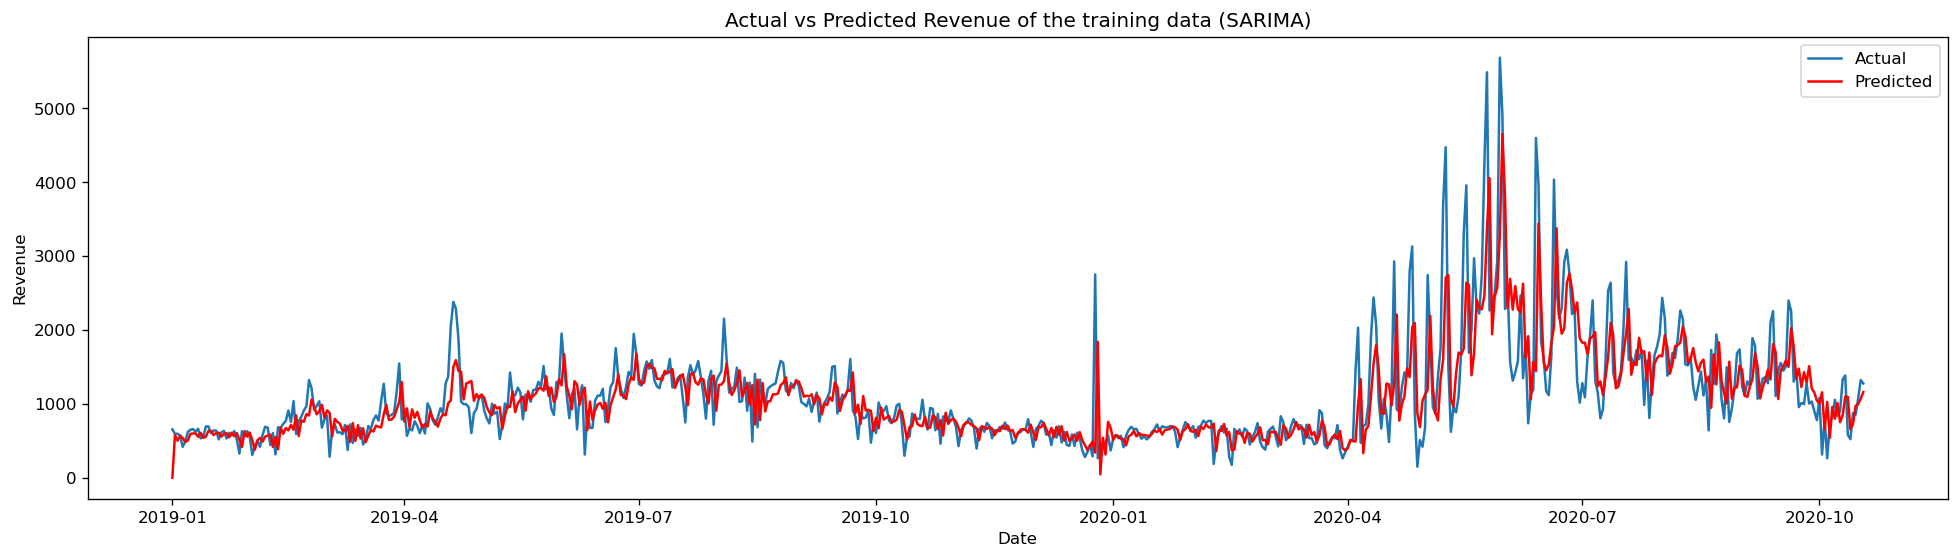

In [49]:
# Use the fitted SARIMAX model to predict for the training data
train_predictions = final_model.predict(start=0, end=len(train_data['actual_revenue_day']) - 1)

# Plot actual vs predicted values
plt.figure(figsize=(20, 5))  # Set figure size
plt.plot(train_data.index, train_data['actual_revenue_day'], label='Actual')
plt.plot(train_data.index, train_predictions, color='red', label='Predicted')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue of the training data (SARIMA)')
plt.legend()

# Show plot
plt.show()

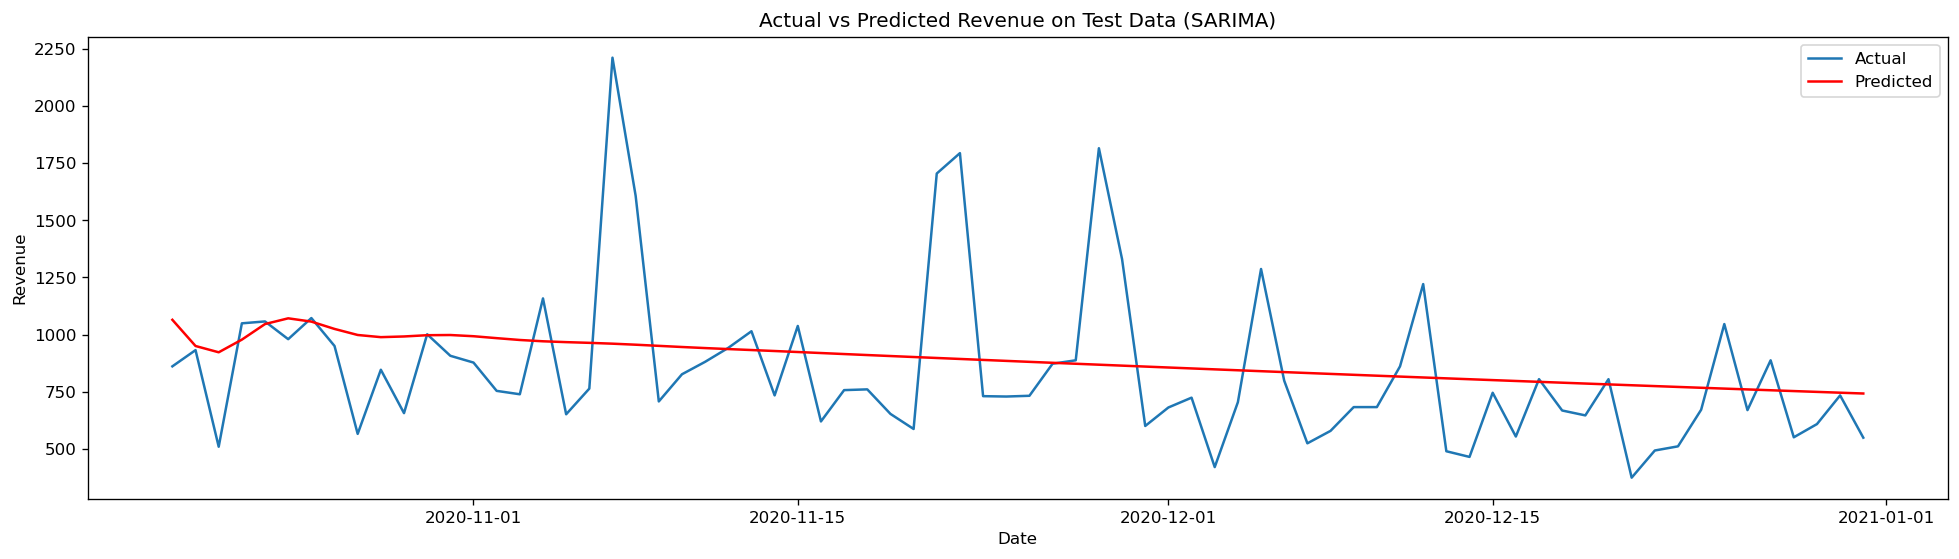

In [50]:
# Forecast future values for the test data
test_forecast_sarima = len(test_data)
test_results_sarima = final_model.forecast(steps=test_forecast_sarima)

# Plot actual vs predicted values for the test data
plt.figure(figsize=(20, 5))
plt.plot(test_data.index, test_data['actual_revenue_day'], label='Actual')
plt.plot(test_data.index, test_results_sarima, color='red', label='Predicted')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue on Test Data (SARIMA)')
plt.legend()

# Show plot
plt.show()

In [51]:
# Calculate RMSE between forecasted values and test data
rmse = np.sqrt(mean_squared_error(test_data['actual_revenue_day'], test_results_sarima[:len(test_data)]))
print("RMSE between predicted values and test data:", rmse)

RMSE between predicted values and test data: 321.35038015417086


### Forecast using the SARIMA model<a id="Forecast using the SARIMA model"></a>

In [53]:
# Forecast future values beyond the test data
forecast_steps = 100  # Forecast for 100 more days
forecast_sarima = final_model.forecast(steps=len(test_data) + forecast_steps)

# Print the forecasted values
print("Forecasted values: (SARIMA)")
print(forecast_sarima)



Forecasted values: (SARIMA)
2020-10-19    1064.799291
2020-10-20     950.281767
2020-10-21     922.749071
2020-10-22     978.137052
2020-10-23    1046.288826
                 ...     
2021-04-06     470.667830
2021-04-07     468.437856
2021-04-08     466.218448
2021-04-09     464.009554
2021-04-10     461.811127
Freq: D, Name: predicted_mean, Length: 174, dtype: float64


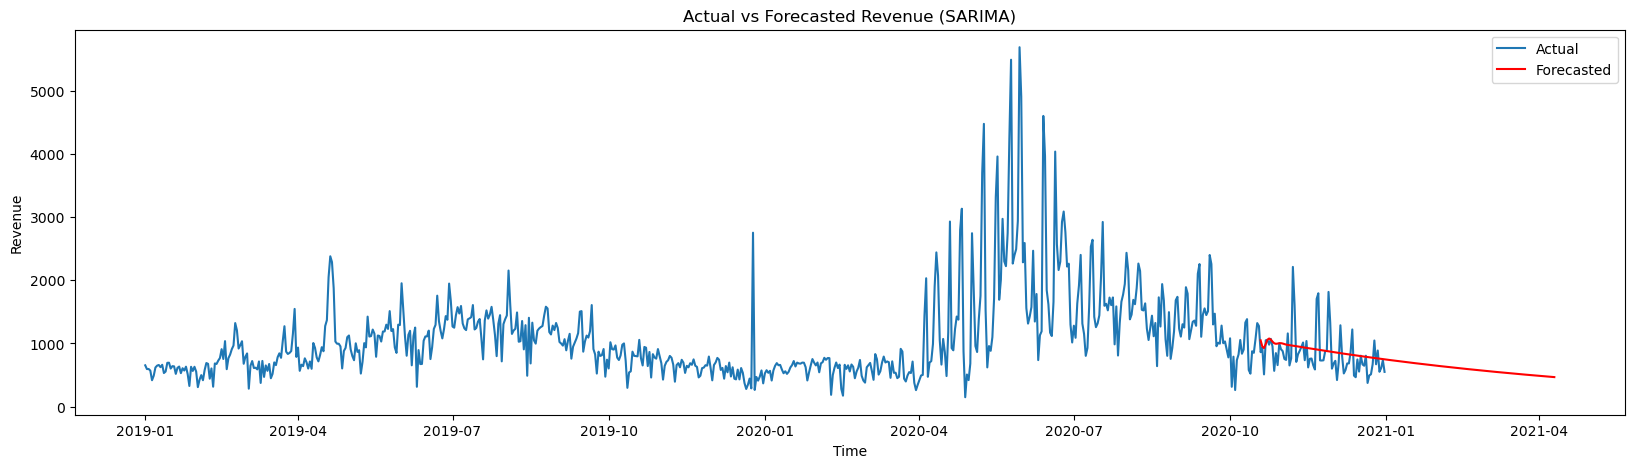

In [33]:
# Plot actual values
plt.figure(figsize=(20, 5))
plt.plot(revenue_df['actual_revenue_day'], label='Actual')

# Forecast for the next 50 steps
forecast_values = final_model.forecast(steps=50)

# Plot forecasted values
plt.plot(forecast.index, forecast_sarima, color='red', label='Forecasted')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Forecasted Revenue (SARIMA)')
plt.legend()

# Show plot
plt.show()

## LSTM - Long Short term memory networks<a id="LSTM - Long Short term memory networks"></a>

In [30]:
data = grouped_result

### Data preprocessing to obtain a vector of previous 7 days of data

In [31]:
# Define the window specification ordering by 'end_date' and including the last 7 rows
windowSpec = Window.orderBy(col('date')).rowsBetween(-7, -1)

# Collect the last 7 days' revenue values into a list within each partition
data = data.withColumn('revenue_list', collect_list('predicted_revenue_day').over(windowSpec))

# Define a condition to check if the length of the list is less than 7
condition = (size(col('revenue_list')) < 7)

# If the length of the list is less than 7, append 0.0 to make it 7 elements long
data = data.withColumn('revenue_list',
                       when(condition,
                            concat(array_repeat(lit(0.0), 7 - size(col('revenue_list'))), col('revenue_list')))
                       .otherwise(col('revenue_list')))



# Splitting the array into separate columns
data = data.withColumn("revenue_list_1", col("revenue_list").getItem(0)) \
           .withColumn("revenue_list_2", col("revenue_list").getItem(1)) \
           .withColumn("revenue_list_3", col("revenue_list").getItem(2)) \
           .withColumn("revenue_list_4", col("revenue_list").getItem(3)) \
           .withColumn("revenue_list_5", col("revenue_list").getItem(4)) \
           .withColumn("revenue_list_6", col("revenue_list").getItem(5)) \
           .withColumn("revenue_list_7", col("revenue_list").getItem(6)) \
           .drop("revenue_list")

data.show(10, truncate=False)

24/04/24 20:34:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:34:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:34:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:34:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:34:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 2

+----------+------------------+---------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|date      |actual_revenue_day|predicted_revenue_day|revenue_list_1|revenue_list_2|revenue_list_3|revenue_list_4|revenue_list_5|revenue_list_6|revenue_list_7|
+----------+------------------+---------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|2019-01-01|653.4             |630.3                |0.0           |0.0           |0.0           |0.0           |0.0           |0.0           |0.0           |
|2019-01-02|594.0             |531.3                |0.0           |0.0           |0.0           |0.0           |0.0           |0.0           |630.3         |
|2019-01-03|595.65            |585.75               |0.0           |0.0           |0.0           |0.0           |0.0           |630.3         |531.3         |
|2019-01-04|569.25            |554.4          

In [32]:
# Sort the data by the 'end_date' column to maintain the temporal order
sorted_data = data.orderBy('date')

# Calculate the number of rows for the train and test sets
total_count = sorted_data.count()
train_count = int(total_count * 0.9)
test_count = total_count - train_count

# Split the data into train and test sets
#count_data = sorted_data.limit(train_count)
train_data = sorted_data.limit(train_count)
test_data = sorted_data.subtract(train_data)


In [33]:
x_train=np.array(train_data.select('revenue_list_1','revenue_list_2','revenue_list_3','revenue_list_4','revenue_list_5','revenue_list_6','revenue_list_7').collect())
x_test=np.array(test_data.select('revenue_list_1','revenue_list_2','revenue_list_3','revenue_list_4','revenue_list_5','revenue_list_6','revenue_list_7').collect())
y_train=np.array(train_data.select('predicted_revenue_day').collect())
y_test =np.array(test_data.select('predicted_revenue_day').collect())

24/04/24 20:37:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:37:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:37:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:37:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:37:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 20:37:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/24 2

In [40]:
print('xtrain shape = {}'.format(x_train.shape))
print('xtest shape = {}'.format(x_test.shape))
print('ytrain shape = {}'.format(y_train.shape))
print('ytest shape = {}'.format(y_test.shape))

xtrain shape = (657, 7)
xtest shape = (74, 7)
ytrain shape = (657, 1)
ytest shape = (74, 1)


In [34]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print('The shape of xtrain is {}: '.format(x_train.shape))
print('The shape of xtest is {}: '.format(x_test.shape))

The shape of xtrain is (657, 1, 7): 
The shape of xtest is (74, 1, 7): 


### Model Training (LSTM)

In [35]:
#Building the LSTM Architecture
model = Sequential()
model.add(LSTM(units=64,activation = 'relu', input_shape=(1,7)))
model.add(Dense(units=7,activation = 'relu'))
model.add(Dense(units=1,activation = 'linear'))
model.compile(loss=MeanSquaredError(), optimizer=Adam(),metrics = [RootMeanSquaredError()])
model.summary()

loss = model.fit(x_train, y_train, batch_size=128, epochs=100,validation_split=(0.1))


predicted_train = model.predict(x_train)
predicted = model.predict(x_test)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,895 (73.81 KB)

 Trainable params: 18,895 (73.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2264766.0000 - root_mean_squared_error: 1503.8955 - val_loss: 1818465.3750 - val_root_mean_squared_error: 1348.5049
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1699275.8750 - root_mean_squared_error: 1303.0066 - val_loss: 1365075.1250 - val_root_mean_squared_error: 1168.3643
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1305430.1250 - root_mean_squared_error: 1142.0583 - val_loss: 1021839.0000 - val_root_mean_squared_error: 1010.8605
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 966108.1250 - root_mean_squared_error: 982.7156 - val_loss: 745462.2500 - val_root_mean_squared_error: 863.4016
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 780268.3125 - root_mean_squared_error: 882.9875 - val_loss: 486822.4375 - val_root_mean_squared_error: 697.7266
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 571693.0625 - root_mean_squared_error: 755.8909 - val_loss: 307916.4062 - val_ro

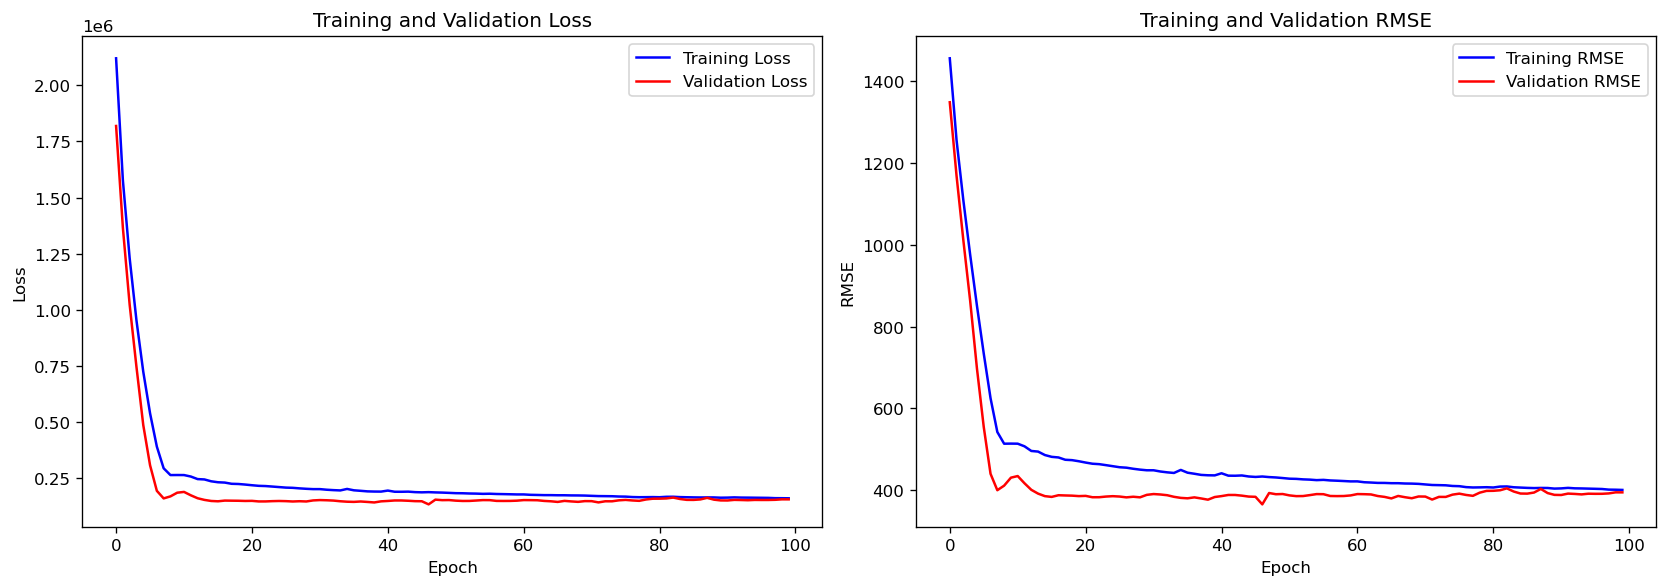

In [36]:
#loss = model.fit(x_train, y_train, batch_size=128, epochs=100,validation_split=(0.1))
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
axes[0].plot(loss.history['loss'], label='Training Loss', color='blue')
axes[0].plot(loss.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot training and validation RMSE
axes[1].plot(loss.history['root_mean_squared_error'], label='Training RMSE', color='blue')
axes[1].plot(loss.history['val_root_mean_squared_error'], label='Validation RMSE', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Training and Validation RMSE')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot 
plt.show()


In [37]:
predicted_train = model.predict(x_train)
predicted = model.predict(x_test)
combined_array_1 = np.concatenate((y_train, predicted_train), axis = 1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


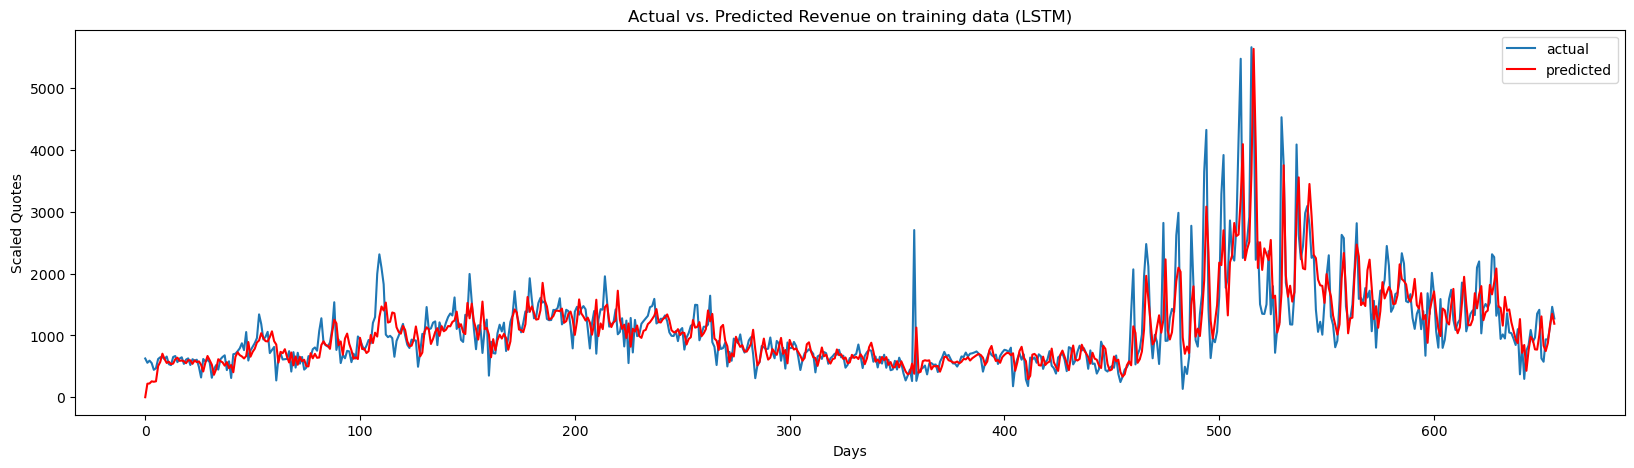

In [49]:
plt.figure(figsize=(20,5))
plt.plot(combined_array_1[:,0], label='actual')
plt.plot(combined_array_1[:,1], color='red', label='predicted')
plt.legend(loc='upper right')  # Changed 'top right' to 'upper right'
plt.title('Actual vs. Predicted Revenue on training data (LSTM)')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()


In [38]:
combined_array = np.concatenate((y_test, predicted), axis = 1)

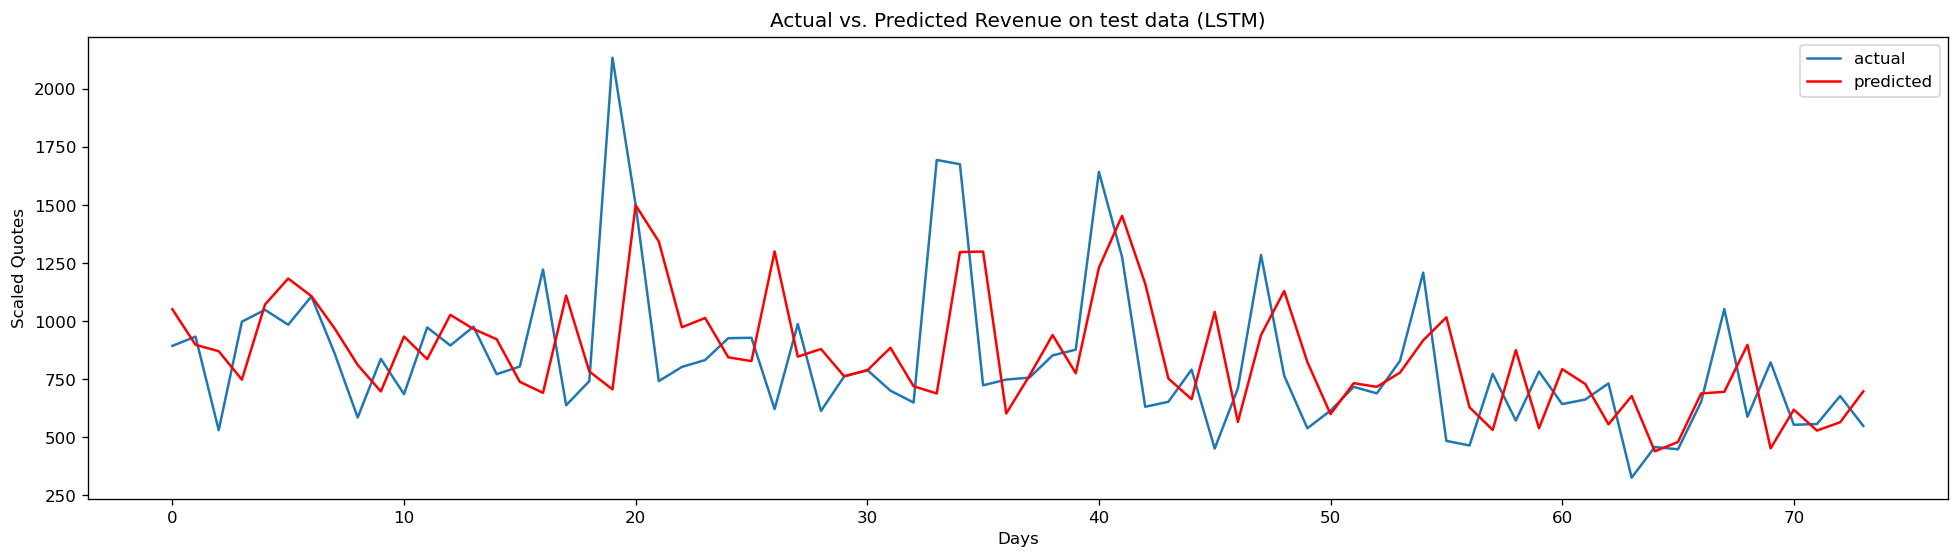

In [39]:
plt.figure(figsize=(20,5))
plt.plot(combined_array[:,0], label='actual')
plt.plot(combined_array[:,1],color='red', label='predicted')
plt.legend(loc = 'upper right')
plt.title('Actual vs. Predicted Revenue on test data (LSTM)')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [40]:
# Calculate the mean squared error for the actual test values (y_test) and predicted values
rmse_test = np.sqrt(mean_squared_error(y_test, predicted))

# Print the mean squared error
print("RMSE between predicted values and Test Data (LSTM):", rmse_test)

RMSE between predicted values and Test Data (LSTM): 327.8628607046046


In [42]:
def forecast_future(model, X, n_steps):
    current_input = X[-1]  # Use the last data point from the test data as the starting point
    forecasts = []
    for _ in range(n_steps):
        # Make forecast for the next time step
        forecast = model.predict(current_input.reshape(1, 1, 7))
        # Update the current input to include the new forecasted value
        current_input = np.roll(current_input, -1)  # Shift the array to the left
        current_input[-1] = forecast  # Update the last element with the forecasted value
        forecasts.append(forecast)
    return forecasts

# Assuming you have x_test available

# Forecast for the next 10 time steps
n_steps = 100
future_forecasts = forecast_future(model, x_test, n_steps)

# Display the forecasted values with time steps
print("Forecasted values for the next {} time steps:".format(len(future_forecasts)))
for i, forecast in enumerate(future_forecasts, 1):
    print("Time Step {}: {:.2f}".format(i, forecast[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

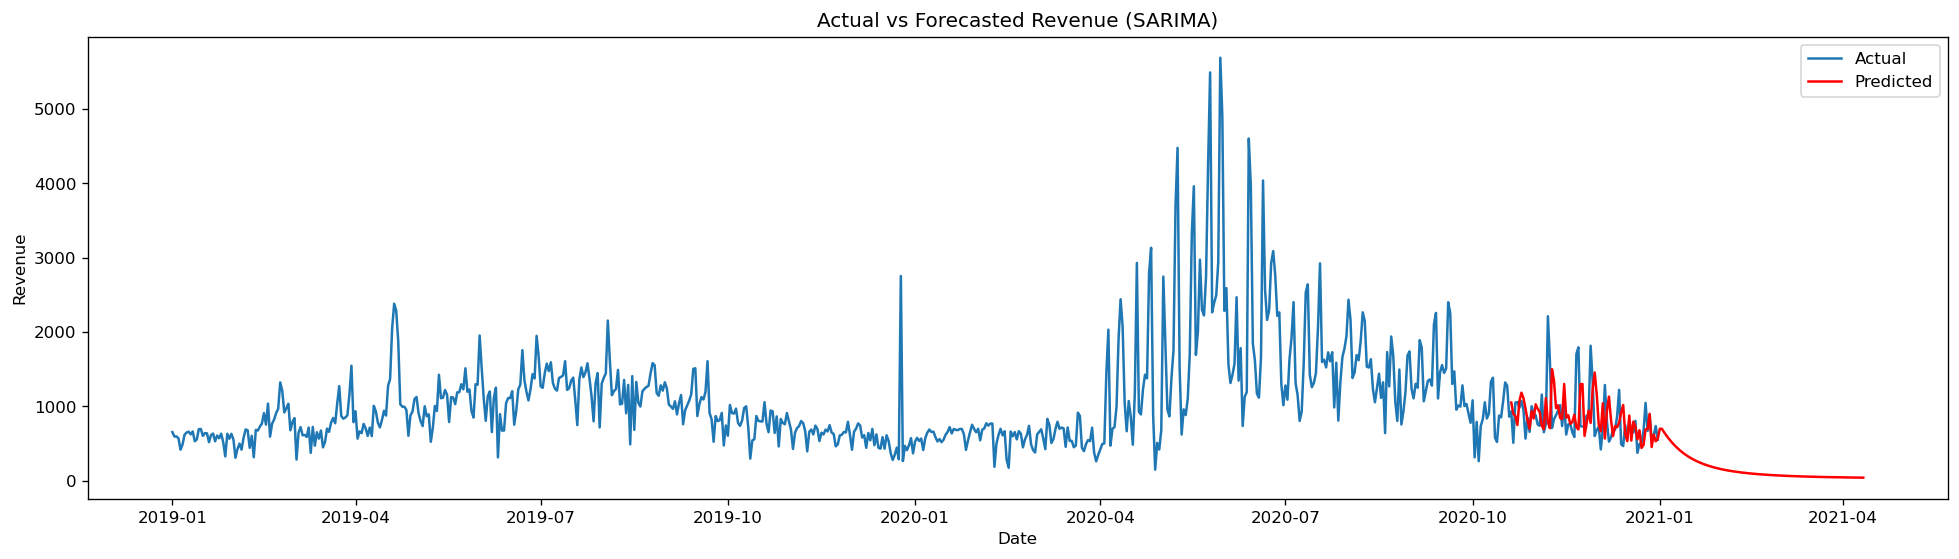

In [43]:
# Initialize an empty list to store the forecasted values
forecast_values_list = []

# Iterate over the arrays in future_forecasts and extract the values
for forecast_array in future_forecasts:
    forecast_value = forecast_array[0][0]  # Extract the forecasted value from the array
    forecast_values_list.append(forecast_value)  # Append the forecasted value to the list
    
# Convert the predicted array to a list
predicted_values_list = [item[0] for item in predicted]

# Combine the predicted values of the test set and the forecasted values
combined_values_list = predicted_values_list + forecast_values_list
    
# Extract the dates of the last 10% split for plotting
last_10_percent_dates = revenue_df.index[-int(len(revenue_df) * 0.1):]
# Calculate the number of additional dates needed
additional_dates_needed = 174 - len(last_10_percent_dates)

# Generate additional dates starting from the last date in the last_10_percent_dates list
start_date = last_10_percent_dates[-1] + pd.Timedelta(days=1)
additional_dates = pd.date_range(start=start_date, periods=additional_dates_needed, freq='D')

# Concatenate existing dates with additional dates
all_dates = last_10_percent_dates.append(additional_dates)

# Create an index for the future forecasted dates
future_dates_index = np.arange(len(revenue_df), len(revenue_df) + len(future_forecasts))

# Plot actual and predicted values along with future forecasted values
plt.figure(figsize=(20, 5))

# Plot actual and predicted values
plt.plot(revenue_df.index, revenue_df['actual_revenue_day'], label='Actual')
plt.plot(all_dates, combined_values_list, color = 'red',label='Predicted')


# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Forecasted Revenue (SARIMA)')
plt.legend()

# Show plot
plt.show()


## Combined Forecasts for the three models<a id="Combined Forecasts for the three models"></a>

In [69]:
# Create a DataFrame from combined_values_list with the same index as predicted_mean
forecast_lstm = pd.DataFrame({'Forecast_LSTM': combined_values_list}, index=forecast_arima.index)


result_df = pd.concat([forecast_arima, forecast_sarima,forecast_lstm], axis=1)
result_df = result_df.rename(columns={'predicted_mean': 'forecast_arima', 
                                      'predicted_mean': 'forecast_sarima', 
                                      'Forecast_LSTM': 'forecast_lstm'})

In [70]:
result_df

,forecast_sarima,forecast_sarima,forecast_lstm
2020-10-19,1082.179890,1064.799291,1051.681519
2020-10-20,1007.556240,950.281767,898.790161
2020-10-21,1037.036864,922.749071,871.165833
2020-10-22,1125.378702,978.137052,748.762024
2020-10-23,1232.835623,1046.288826,1072.312256
...,...,...,...
2021-04-06,1083.717002,470.667830,42.229145
2021-04-07,1081.204483,468.437856,41.870224
2021-04-08,1084.439346,466.218448,41.521614
2021-04-09,1090.841976,464.009554,41.182892
